# Clustering Players

The goal is to cluster batsman with their performances and then try to answer questions like:

1. Identify the players who perform like Virat Kohli? (Top-class)
2. How many players fall into the same bucket as Maxwell and Jadeja? (Explosive X-factor)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import datetime as dt

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score

from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree
from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
from math import isnan

# Suppress warnings
import warnings

warnings.filterwarnings("ignore")

# Loading Dataset

In [3]:
df = pd.read_csv(
    "final_data/player_{team_name_id_role}_with_career_summary_batting.csv"
)
df

team_name           player_name  player_id          player_role  \
0    Afghanistan  Hashmatullah Shahidi     440970     Top order Batter   
1    Afghanistan    Rahmanullah Gurbaz     974087  Wicketkeeper Batter   
2    Afghanistan        Ibrahim Zadran     921509       Opening Batter   
3    Afghanistan          Reyaz Hassan    1061090               Batter   
4    Afghanistan   Rahmat Shah Zurmati     533956           Allrounder   
..           ...                   ...        ...                  ...   
145    Sri Lanka      Dunith Wellalage    1152427               Bowler   
146    Sri Lanka         Kasun Rajitha     499594               Bowler   
147    Sri Lanka   Matheesha Pathirana    1194795               Bowler   
148    Sri Lanka         Lahiru Kumara     784375               Bowler   
149    Sri Lanka    Dilshan Madushanka     793007               Bowler   

          Span  Mat Inns   NO  Runs     HS    Ave     BF     SR 100  50   0  \
0    2013-2023   70   70   11  2001    97*  33.91   2962  67.55   0  18   5   
1    2021-2023   32   32    1  1182    151  38.12   1349  87.62   5   4   1   
2    2019-2023   25   25    2  1123    162  48.82   1366  82.21   4   5   2   
3    2022-2023    5    4    0   120     50  30.00    192  62.50   0   1   0   
4    2013-2023  103   99    4  3481    114  36.64   4902  71.01   5  25   5   
..         ...  ...  ...  ...   ...    ...    ...    ...    ...  ..  ..  ..   
145         18   15    3  207   42*  17.25    269  76.95      0   0   3  16   
146  2018-2023   32   17    7   103     33  10.30    165  62.42   0   0   3   
147         12    7    2   11     5   2.20     35  31.42      0   0   2   2   
148  2017-2023   28   16    6    55     10   5.50    122  45.08   0   0   1   
149         12    6    6    9    4*      -     19  47.36      0   0   0   2   

      4s   6s  
0    173   12  
1    107   44  
2    119   15  
3     12    2  
4    300   38  
..   ...  ...  
145    5  NaN  
146   12    1  
147    0  NaN  
148    7    1  
149    0  NaN  

[150 rows x 18 columns]

# Preprocessing Data

In [4]:
df.isnull().sum()

team_name       0
player_name     0
player_id       0
player_role     1
Span            0
Mat             0
Inns            0
NO              0
Runs            0
HS              0
Ave             0
BF              0
SR              0
100             0
50              0
0               0
4s              1
6s             24
dtype: int64

In [5]:
df[df.isnull().any(axis=1)]

team_name           player_name  player_id          player_role  \
11    Afghanistan   Noor Ahmad Lakanwal    1182529               Bowler   
13    Afghanistan  Abdul Rahman Rahmani     819507               Bowler   
16      Australia           Steve Smith       7656       Opening Batter   
18      Australia           Josh Inglis     662235  Wicketkeeper Batter   
32     Bangladesh    Tanzid Hasan Tamim     990023       Opening Batter   
34     Bangladesh         Tawhid Hridoy     990031     Top order Batter   
38     Bangladesh           Nasum Ahmed     348049               Bowler   
44     Bangladesh    Tanzim Hasan Sakib    1139520               Bowler   
47        England          Gus Atkinson    1039481               Bowler   
49        England           Harry Brook     911707               Batter   
76    Netherlands            Max O'Dowd     643197                  NaN   
78    Netherlands          Vikram Singh      35281       Opening Batter   
79    Netherlands       Teja Nidamanuru    1129328           Allrounder   
88    Netherlands          Shariz Ahmad    1278252               Bowler   
89    Netherlands   Sybrand Engelbrecht     315035           Allrounder   
99    New Zealand        Glenn Phillips     823509  Wicketkeeper Batter   
100   New Zealand       Rachin Ravindra     959767   Batting Allrounder   
109      Pakistan     Abdullah Shafique     922941     Top order Batter   
113      Pakistan       Salman Ali Agha     623977           Allrounder   
115      Pakistan             Usama Mir     647667               Bowler   
121  South Africa        Gerald Coetzee     596010               Bowler   
143     Sri Lanka       Dushan Hemantha     721041           Allrounder   
145     Sri Lanka      Dunith Wellalage    1152427               Bowler   
147     Sri Lanka   Matheesha Pathirana    1194795               Bowler   
149     Sri Lanka    Dilshan Madushanka     793007               Bowler   

          Span  Mat Inns   NO  Runs     HS    Ave      BF     SR 100  50   0  \
11           4    2    1    5     3   5.00      8   62.50      0   0   0   0   
13           3    3    1   10    4*   5.00     37   27.02      0   0   0   0   
16   1983-1985   28   24    2   861    117  39.13    1319  65.27   2   8   1   
18          13   13    0  271    58  20.84    265  102.26      0   2   1  28   
32          12   11    0  134    51  12.18    144   93.05      0   1   2  21   
34          22   19    1  593    92  32.94    724   81.90      0   5   1  43   
38          14    8    2  149    44  24.83    164   90.85      0   0   0  17   
44           2    1    1   14   14*      -      8  175.00      0   0   0   1   
47           4    2    0   37    35  18.50     24  154.16      0   0   0   7   
49          10   10    0  251    80  25.10    272   92.27      0   2   1  26   
76   2019-2023   39   39    2  1219     90  32.94    1672  72.90   0  10   3   
78           2    1    0    8     8   8.00     13   61.53      0   0   0   1   
79          25   25    3  570   111  25.90    621   91.78      2   2   4  43   
88          12    9    1   70    30   8.75    116   60.34      0   0   0   3   
89           5    5    0  164    70  32.80    235   69.78      0   1   0  12   
99          26   20    2  576    72  32.00    636   90.56      0   3   0  40   
100         18   14    1  595  123*  45.76    546  108.97      2   3   1  52   
109         10   10    0  412   113  41.20    460   89.56      1   4   0  38   
113         19   16    5  436    58  39.63    452   96.46      0   3   0  38   
115         12    6    0   40    20   6.66     34  117.64      0   0   2   2   
121         11    6    0   38    22   6.33     51   74.50      0   0   1   2   
143          4    3    2   39    22  39.00     38  102.63      0   0   0   3   
145         18   15    3  207   42*  17.25    269   76.95      0   0   3  16   
147         12    7    2   11     5   2.20     35   31.42      0   0   2   2   
149         12    6    6    9    4*      -     19   47.36

In [6]:
df["6s"] = df["6s"].fillna(0)
df["4s"] = df["4s"].fillna(0)

In [7]:
df[df.isnull().any(axis=1)]

team_name player_name  player_id player_role       Span  Mat Inns NO  \
76  Netherlands  Max O'Dowd     643197         NaN  2019-2023   39   39  2   

    Runs  HS    Ave    BF     SR 100  50  0   4s  6s  
76  1219  90  32.94  1672  72.90   0  10  3  123  15

In [8]:
# Replace null value with 'Opening Batter'

df["player_role"] = df["player_role"].fillna("Opening Batter")
df.isnull().sum()

team_name      0
player_name    0
player_id      0
player_role    0
Span           0
Mat            0
Inns           0
NO             0
Runs           0
HS             0
Ave            0
BF             0
SR             0
100            0
50             0
0              0
4s             0
6s             0
dtype: int64

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 18 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   team_name    150 non-null    object
 1   player_name  150 non-null    object
 2   player_id    150 non-null    int64 
 3   player_role  150 non-null    object
 4   Span         150 non-null    object
 5   Mat          150 non-null    int64 
 6   Inns         150 non-null    object
 7   NO           150 non-null    object
 8   Runs         150 non-null    object
 9   HS           150 non-null    object
 10  Ave          150 non-null    object
 11  BF           150 non-null    object
 12  SR           150 non-null    object
 13  100          150 non-null    object
 14  50           150 non-null    object
 15  0            150 non-null    object
 16  4s           150 non-null    object
 17  6s           150 non-null    object
dtypes: int64(2), object(16)
memory usage: 21.2+ KB


In [10]:
df["team_name"] = df["team_name"].astype("category")
df["player_name"] = df["player_name"].astype("category")
df["player_role"] = df["player_role"].astype("category")
df["Span"] = df["Span"].astype("category")

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 18 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   team_name    150 non-null    category
 1   player_name  150 non-null    category
 2   player_id    150 non-null    int64   
 3   player_role  150 non-null    category
 4   Span         150 non-null    category
 5   Mat          150 non-null    int64   
 6   Inns         150 non-null    object  
 7   NO           150 non-null    object  
 8   Runs         150 non-null    object  
 9   HS           150 non-null    object  
 10  Ave          150 non-null    object  
 11  BF           150 non-null    object  
 12  SR           150 non-null    object  
 13  100          150 non-null    object  
 14  50           150 non-null    object  
 15  0            150 non-null    object  
 16  4s           150 non-null    object  
 17  6s           150 non-null    object  
dtypes: category(4), int64(2), obje

In [12]:
df["Inns"] = df["Inns"].replace("-", 0)
df["Inns"] = df["Inns"].astype("int64")

In [13]:
df["NO"] = df["NO"].replace("-", 0)
df["NO"] = df["NO"].astype("int64")

In [14]:
df["Runs"] = df["Runs"].replace("-", "0")
df["Runs"].replace(to_replace="\*", value="", regex=True, inplace=True)
df["Runs"].unique()

array(['2001', '1182', '1123', '120', '3481', '2060', '3194', '315',
       '340', '1267', '228', '3', '16', '4', '35', '456', '861', '1814',
       '58', '395', '2173', '1469', '2456', '3691', '1446', '6810', '256',
       '542', '7488', '2475', '51', '995', '92', '7577', '5294', '1215',
       '44', '199', '160', '45', '77', '14', '4928', '2301', '3794', '80',
       '418', '494', '1282', '805', '6421', '3207', '627', '157', '1437',
       '10510', '1769', '2021', '13437', '1935', '2507', '2683', '707',
       '329', '89', '37', '179', '212', '933', '718', '1416', '1219',
       '879', '8', '111', '86', '363', '137', '457', '154', '43', '1234',
       '191', '30', '70', '6632', '205', '416', '1151', '116', '255',
       '3944', '1347', '1495', '72', '123', '1313', '201', '724', '991',
       '5625', '851', '3365', '3138', '113', '2052', '288', '611', '406',
       '20', '33', '383', '171', '64', '1454', '22', '6607', '858', '408',
       '1623', '781', '209', '4257', '91', '344', '20

In [15]:
df["Runs"] = df["Runs"].apply(lambda x: int(x) if x.isdigit() else x)

In [16]:
df["HS"] = df["HS"].replace("-", "0")
df["HS"].replace(to_replace="\*", value="", regex=True, inplace=True)
df["HS"] = df["HS"].astype("float")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 18 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   team_name    150 non-null    category
 1   player_name  150 non-null    category
 2   player_id    150 non-null    int64   
 3   player_role  150 non-null    category
 4   Span         150 non-null    category
 5   Mat          150 non-null    int64   
 6   Inns         150 non-null    int64   
 7   NO           150 non-null    int64   
 8   Runs         150 non-null    int64   
 9   HS           150 non-null    float64 
 10  Ave          150 non-null    object  
 11  BF           150 non-null    object  
 12  SR           150 non-null    object  
 13  100          150 non-null    object  
 14  50           150 non-null    object  
 15  0            150 non-null    object  
 16  4s           150 non-null    object  
 17  6s           150 non-null    object  
dtypes: category(4), float64(1), in

In [17]:
df["Ave"] = df["Ave"].replace("-", "0")
df["Ave"] = df["Ave"].astype("float")

df["BF"] = df["BF"].replace("-", "0")
df["BF"] = df["BF"].astype("float")

df["SR"] = df["SR"].replace("-", "0")
df["SR"] = df["SR"].astype("float")

df["100"] = df["100"].replace("-", "0")
df["100"] = df["100"].astype("int64")

df["50"] = df["50"].replace("-", "0")
df["50"] = df["50"].astype("int64")

df["0"] = df["0"].replace("-", "0")
df["0"] = df["0"].astype("int64")

df["4s"] = df["4s"].replace("-", "0")
df["4s"] = df["4s"].astype("int64")

df["6s"] = df["6s"].replace("-", "0")
df["6s"] = df["6s"].astype("int64")

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 18 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   team_name    150 non-null    category
 1   player_name  150 non-null    category
 2   player_id    150 non-null    int64   
 3   player_role  150 non-null    category
 4   Span         150 non-null    category
 5   Mat          150 non-null    int64   
 6   Inns         150 non-null    int64   
 7   NO           150 non-null    int64   
 8   Runs         150 non-null    int64   
 9   HS           150 non-null    float64 
 10  Ave          150 non-null    float64 
 11  BF           150 non-null    float64 
 12  SR           150 non-null    float64 
 13  100          150 non-null    int64   
 14  50           150 non-null    int64   
 15  0            150 non-null    int64   
 16  4s           150 non-null    int64   
 17  6s           150 non-null    int64   
dtypes: category(4), float64(4), in

In [19]:
df[["start", "end"]] = df.Span.str.split("-", expand=True)

df.dropna(inplace=True)
df.drop(["Span", "player_id"], axis=1, inplace=True)
df

team_name           player_name          player_role  Mat  Inns  NO  \
0    Afghanistan  Hashmatullah Shahidi     Top order Batter   70    70  11   
1    Afghanistan    Rahmanullah Gurbaz  Wicketkeeper Batter   32    32   1   
2    Afghanistan        Ibrahim Zadran       Opening Batter   25    25   2   
3    Afghanistan          Reyaz Hassan               Batter    5     4   0   
4    Afghanistan   Rahmat Shah Zurmati           Allrounder  103    99   4   
..           ...                   ...                  ...  ...   ...  ..   
141    Sri Lanka      Charith Asalanka   Batting Allrounder   47    41   5   
142    Sri Lanka   Dhananjaya de Silva           Allrounder   88    80  10   
144    Sri Lanka    Maheesh Theekshana               Bowler   32    17   6   
146    Sri Lanka         Kasun Rajitha               Bowler   32    17   7   
148    Sri Lanka         Lahiru Kumara               Bowler   28    16   6   

     Runs     HS    Ave      BF     SR  100  50  0   4s  6s start   end  
0    2001   97.0  33.91  2962.0  67.55    0  18  5  173  12  2013  2023  
1    1182  151.0  38.12  1349.0  87.62    5   4  1  107  44  2021  2023  
2    1123  162.0  48.82  1366.0  82.21    4   5  2  119  15  2019  2023  
3     120   50.0  30.00   192.0  62.50    0   1  0   12   2  2022  2023  
4    3481  114.0  36.64  4902.0  71.01    5  25  5  300  38  2013  2023  
..    ...    ...    ...     ...    ...  ...  .. ..  ...  ..   ...   ...  
141  1443  110.0  40.08  1626.0  88.74    1  10  2  116  28  2021  2023  
142  1812   93.0  25.88  2313.0  78.33    0  10  4  180  15  2016  2023  
144   149   29.0  13.54   252.0  59.12    0   0  4    8   2  2021  2023  
146   103   33.0  10.30   165.0  62.42    0   0  3   12   1  2018  2023  
148    55   10.0   5.50   122.0  45.08    0   0  1    7   1  2017  2023  

[127 rows x 18 columns]

# Data Visualization

## Univariate Analysis

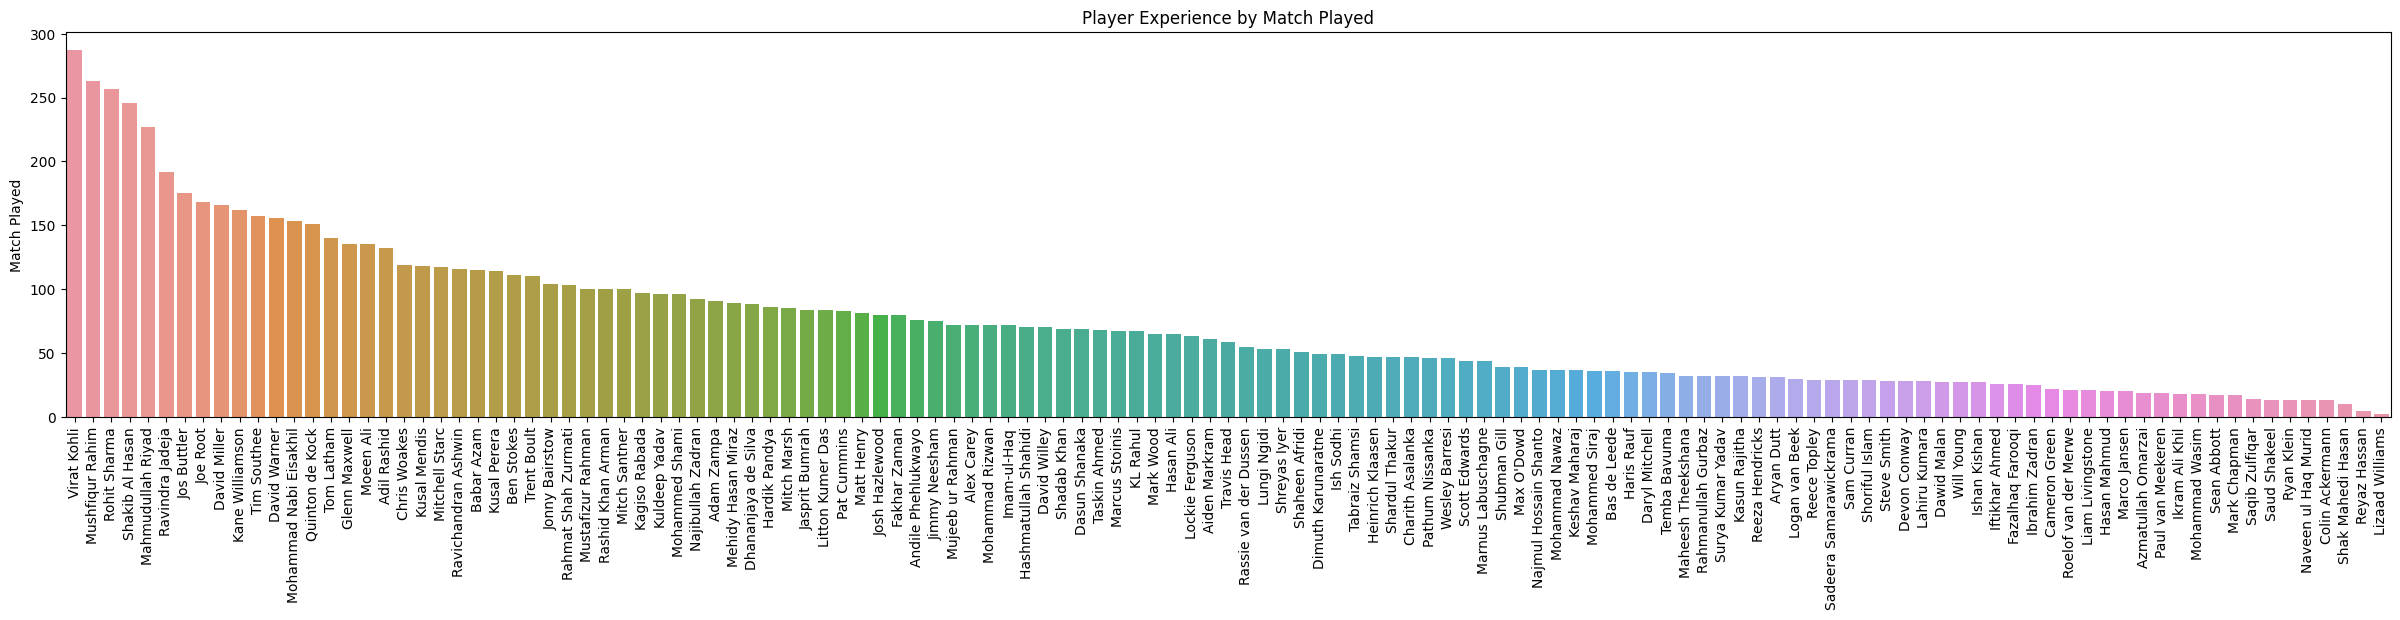

In [20]:
plt.figure(figsize=(30, 5))
mat = df[["player_name", "Mat"]].sort_values("Mat", ascending=False)
ax = sns.barplot(x="player_name", y="Mat", data=mat, order=mat["player_name"])
ax.set(xlabel="", ylabel="Match Played", title="Player Experience by Match Played")
plt.xticks(rotation=90)
plt.show()

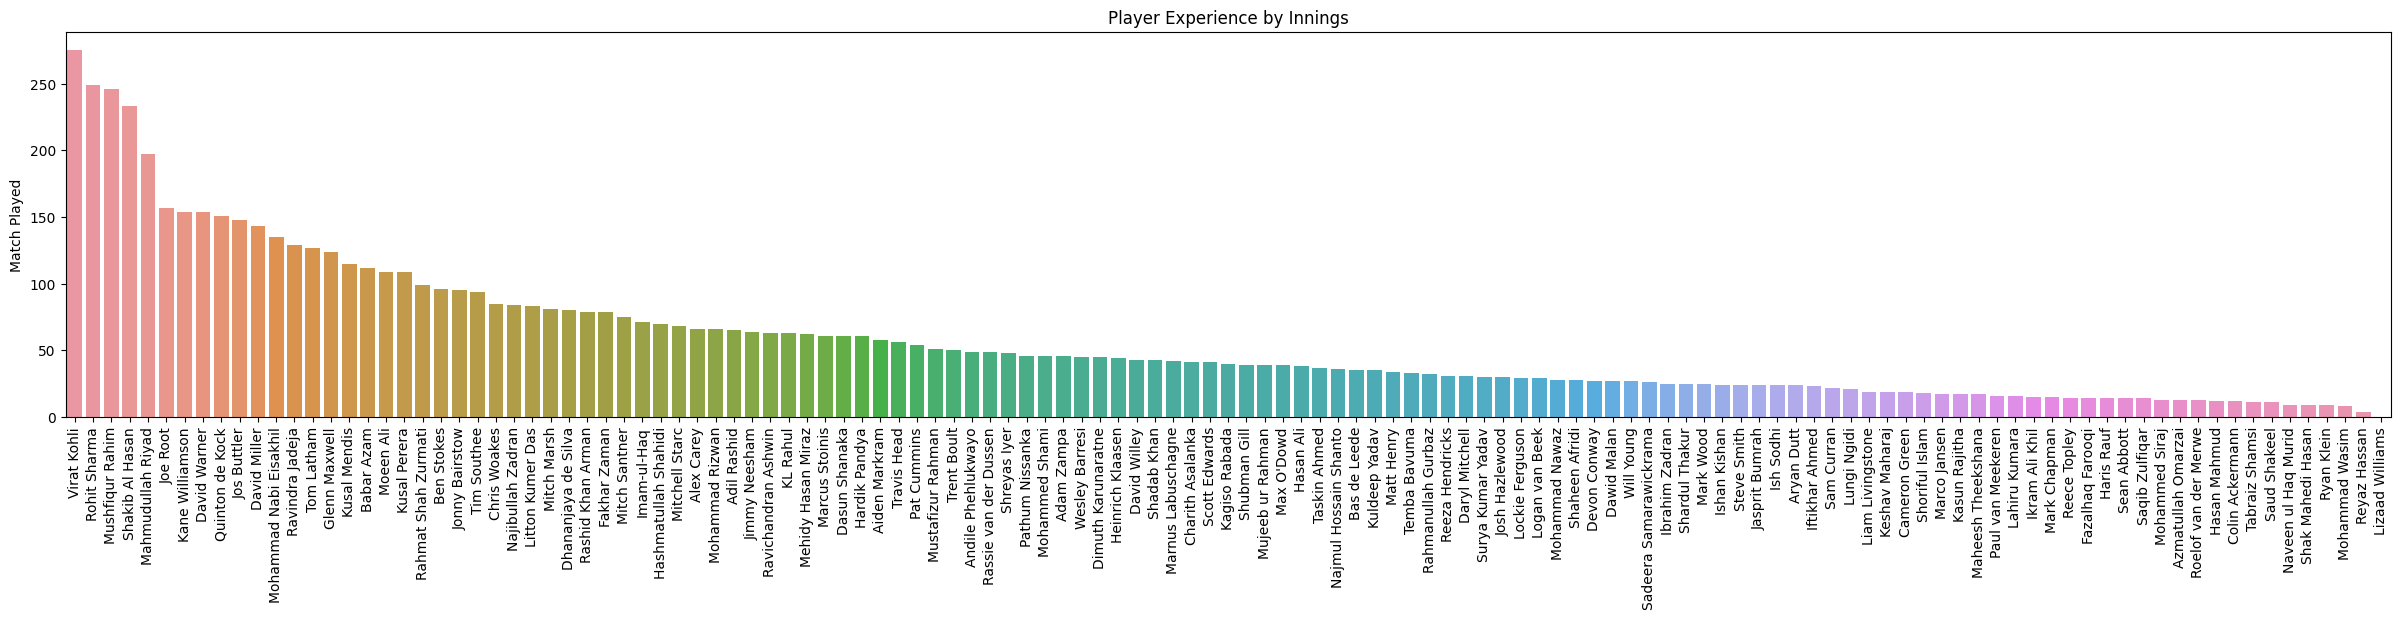

In [21]:
plt.figure(figsize=(30, 5))
mat = df[["player_name", "Inns"]].sort_values("Inns", ascending=False)
ax = sns.barplot(x="player_name", y="Inns", data=mat, order=mat["player_name"])
ax.set(xlabel="", ylabel="Match Played", title="Player Experience by Innings")
plt.xticks(rotation=90)
plt.show()

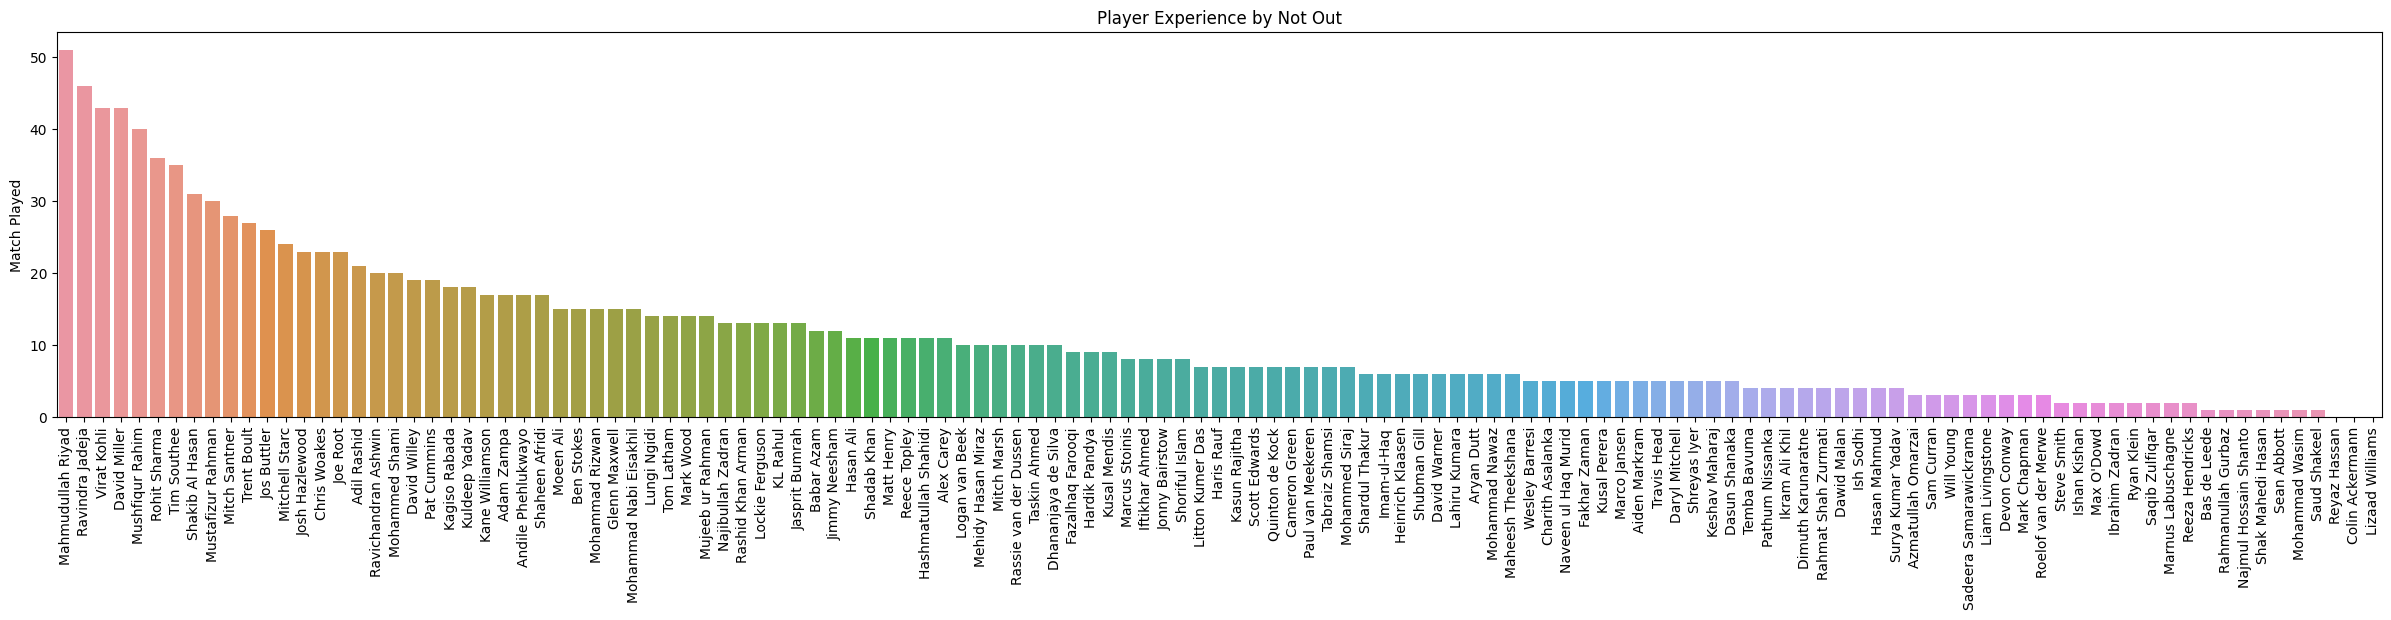

In [22]:
# Not Out Players
plt.figure(figsize=(30, 5))
mat = df[["player_name", "NO"]].sort_values("NO", ascending=False)
ax = sns.barplot(x="player_name", y="NO", data=mat, order=mat["player_name"])
ax.set(xlabel="", ylabel="Match Played", title="Player Experience by Not Out")
plt.xticks(rotation=90)
plt.show()

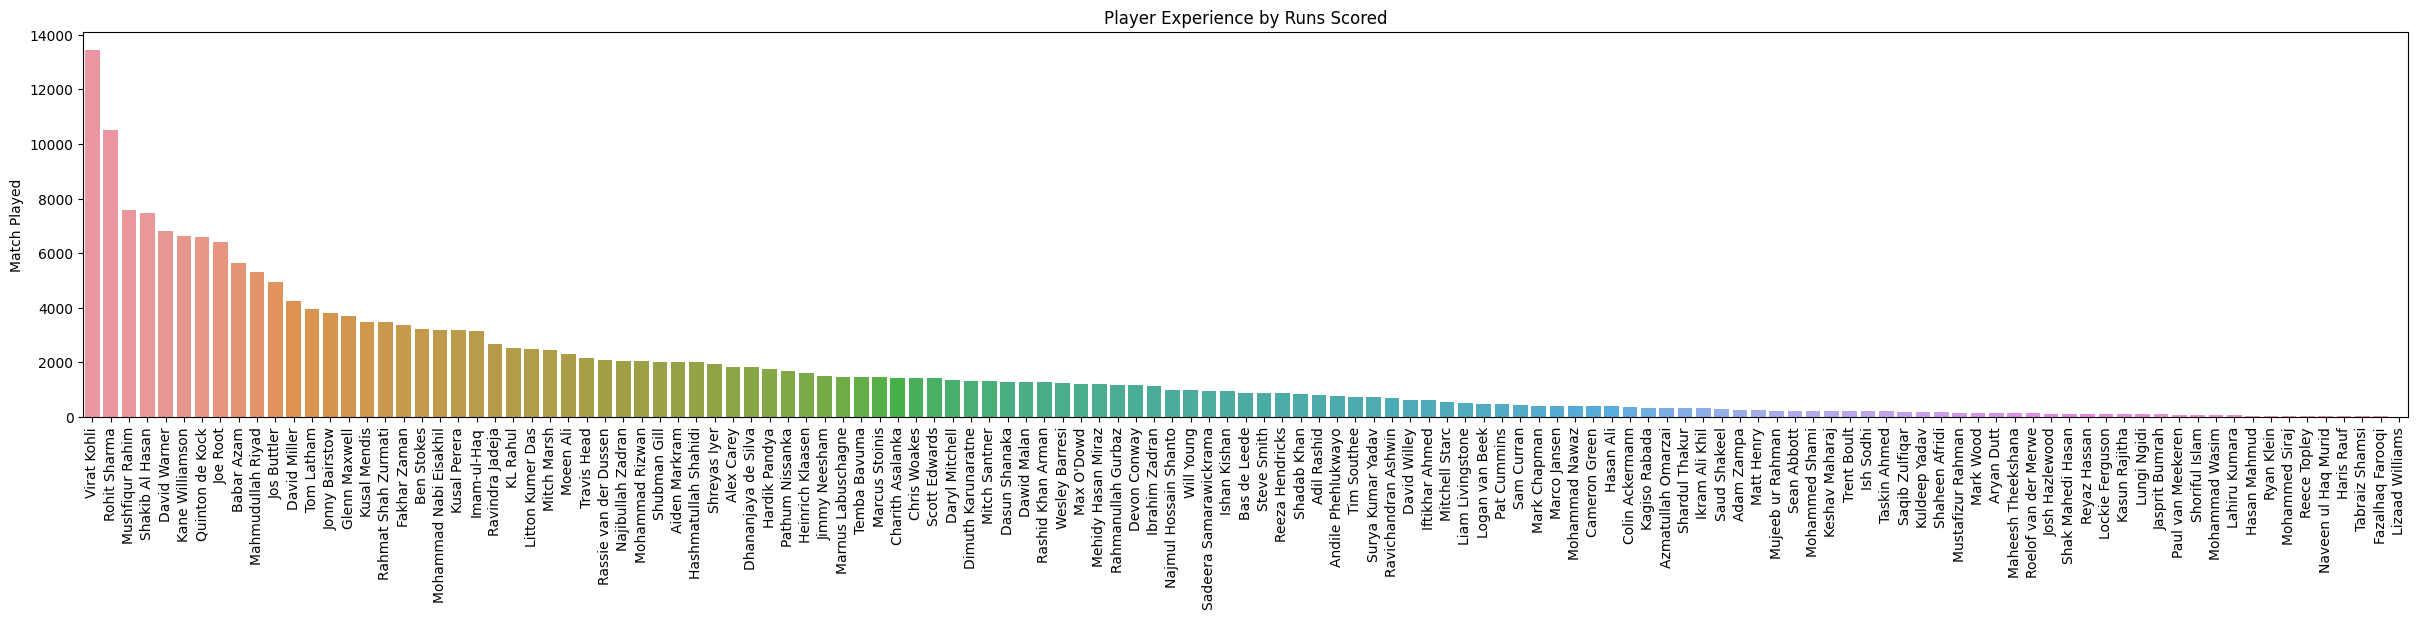

In [23]:
# By Runs Scored

plt.figure(figsize=(30, 5))
mat = df[["player_name", "Runs"]].sort_values("Runs", ascending=False)
ax = sns.barplot(x="player_name", y="Runs", data=mat, order=mat["player_name"])
ax.set(xlabel="", ylabel="Match Played", title="Player Experience by Runs Scored")
plt.xticks(rotation=90)
plt.show()

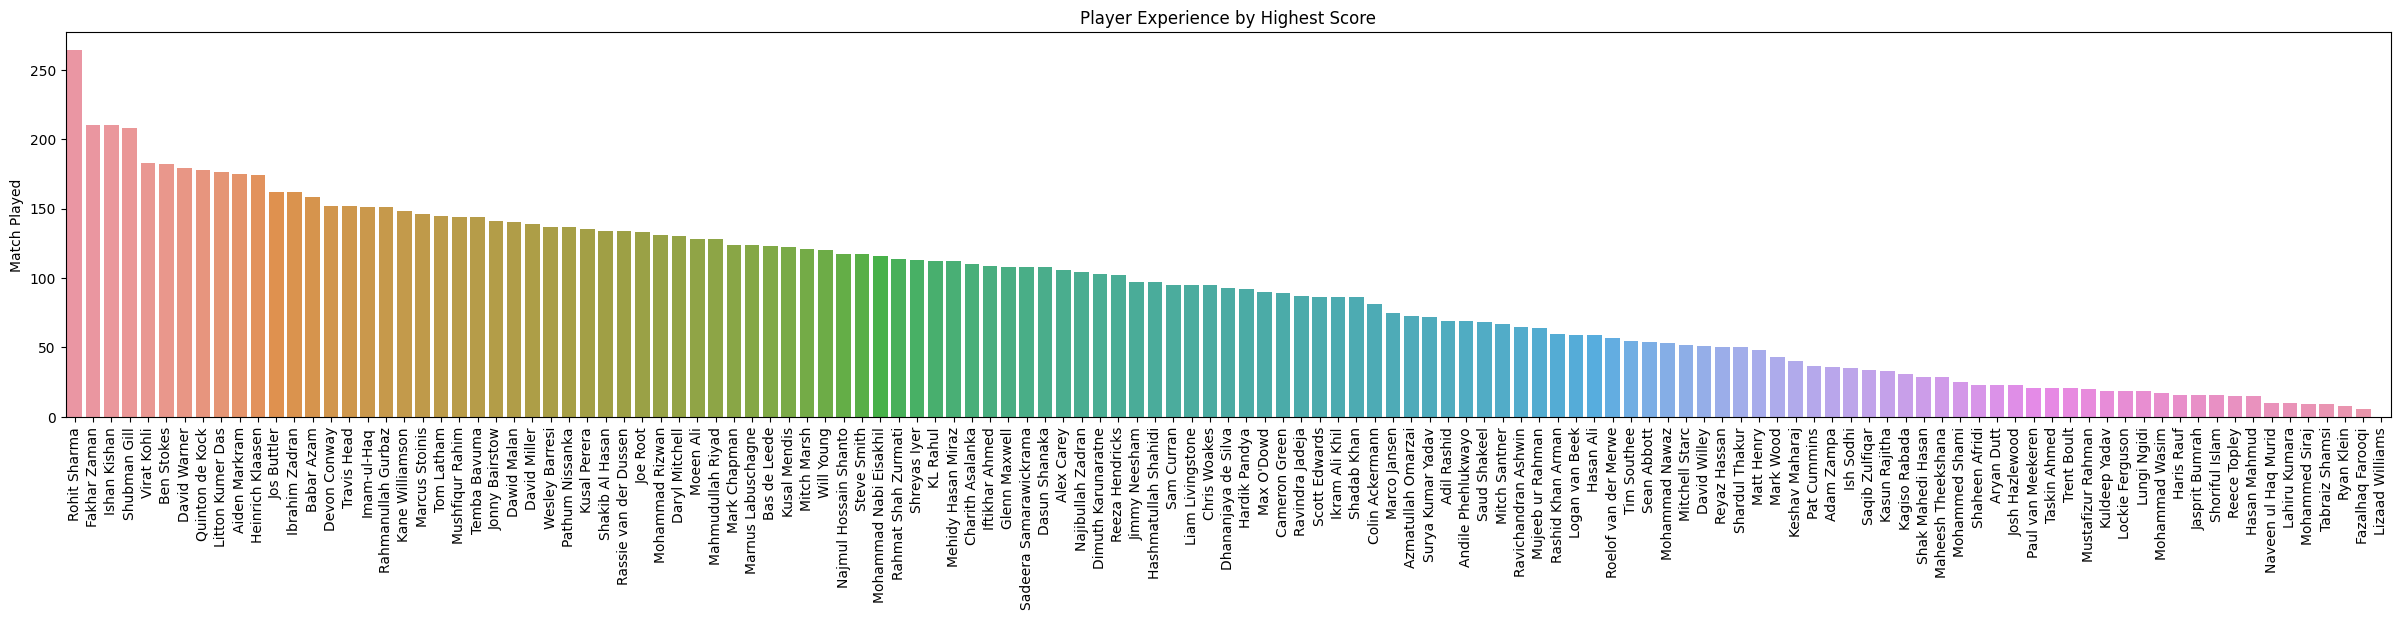

In [24]:
# By Highest Score

plt.figure(figsize=(30, 5))
mat = df[["player_name", "HS"]].sort_values("HS", ascending=False)
ax = sns.barplot(x="player_name", y="HS", data=mat, order=mat["player_name"])
ax.set(xlabel="", ylabel="Match Played", title="Player Experience by Highest Score")
plt.xticks(rotation=90)
plt.show()

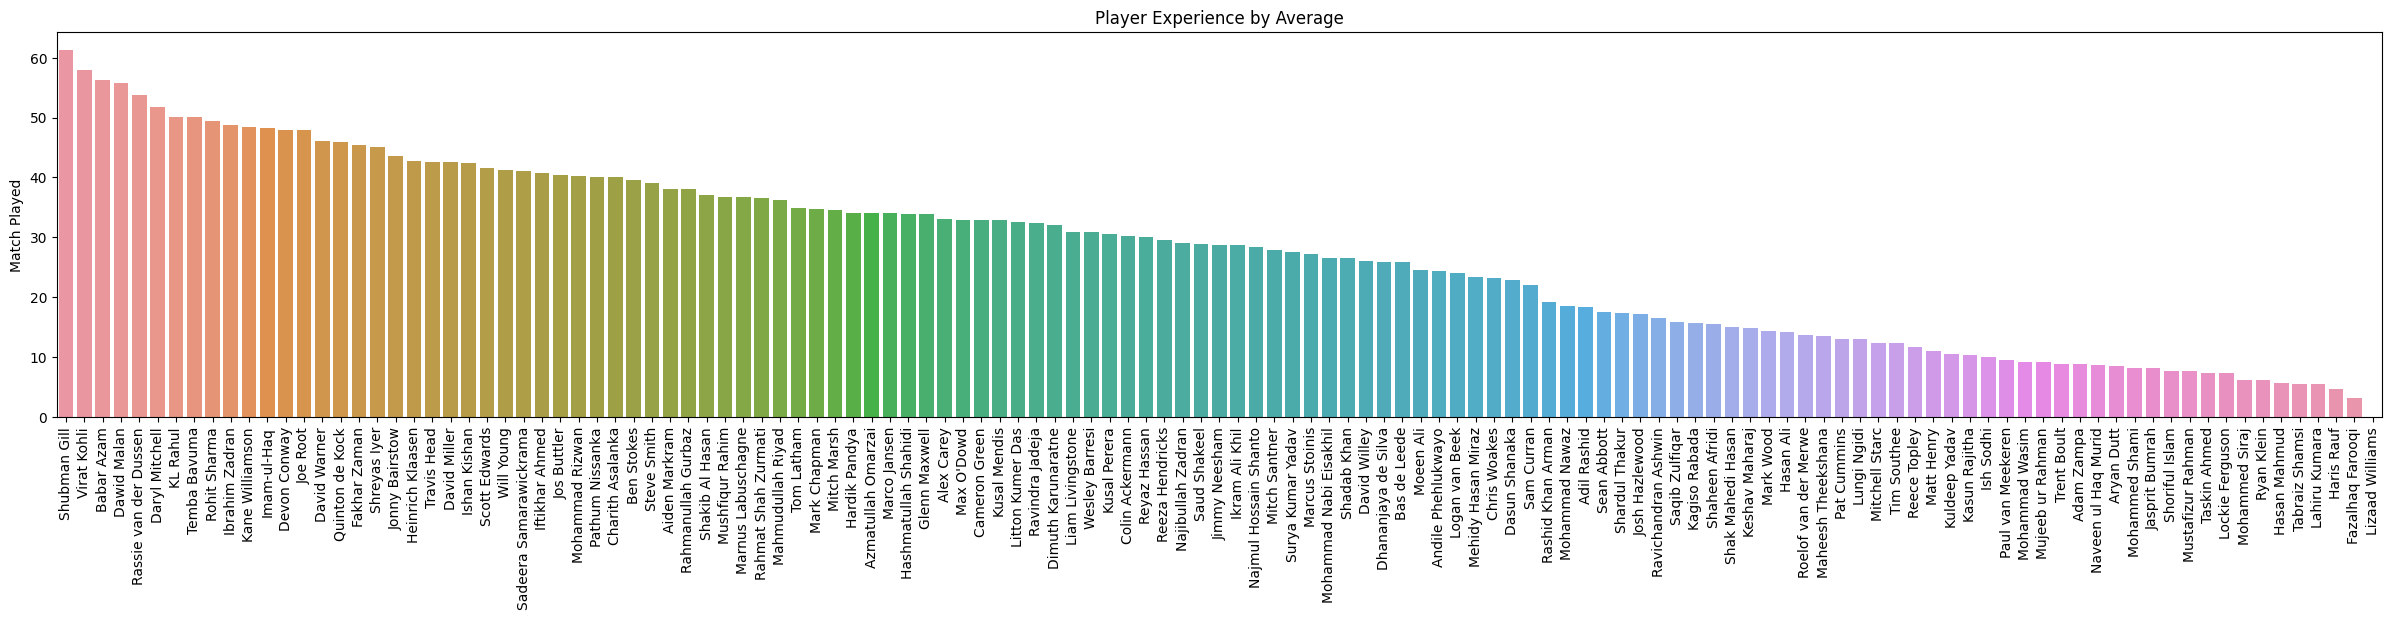

In [25]:
# By Average

plt.figure(figsize=(30, 5))
mat = df[["player_name", "Ave"]].sort_values("Ave", ascending=False)
ax = sns.barplot(x="player_name", y="Ave", data=mat, order=mat["player_name"])
ax.set(xlabel="", ylabel="Match Played", title="Player Experience by Average")
plt.xticks(rotation=90)
plt.show()

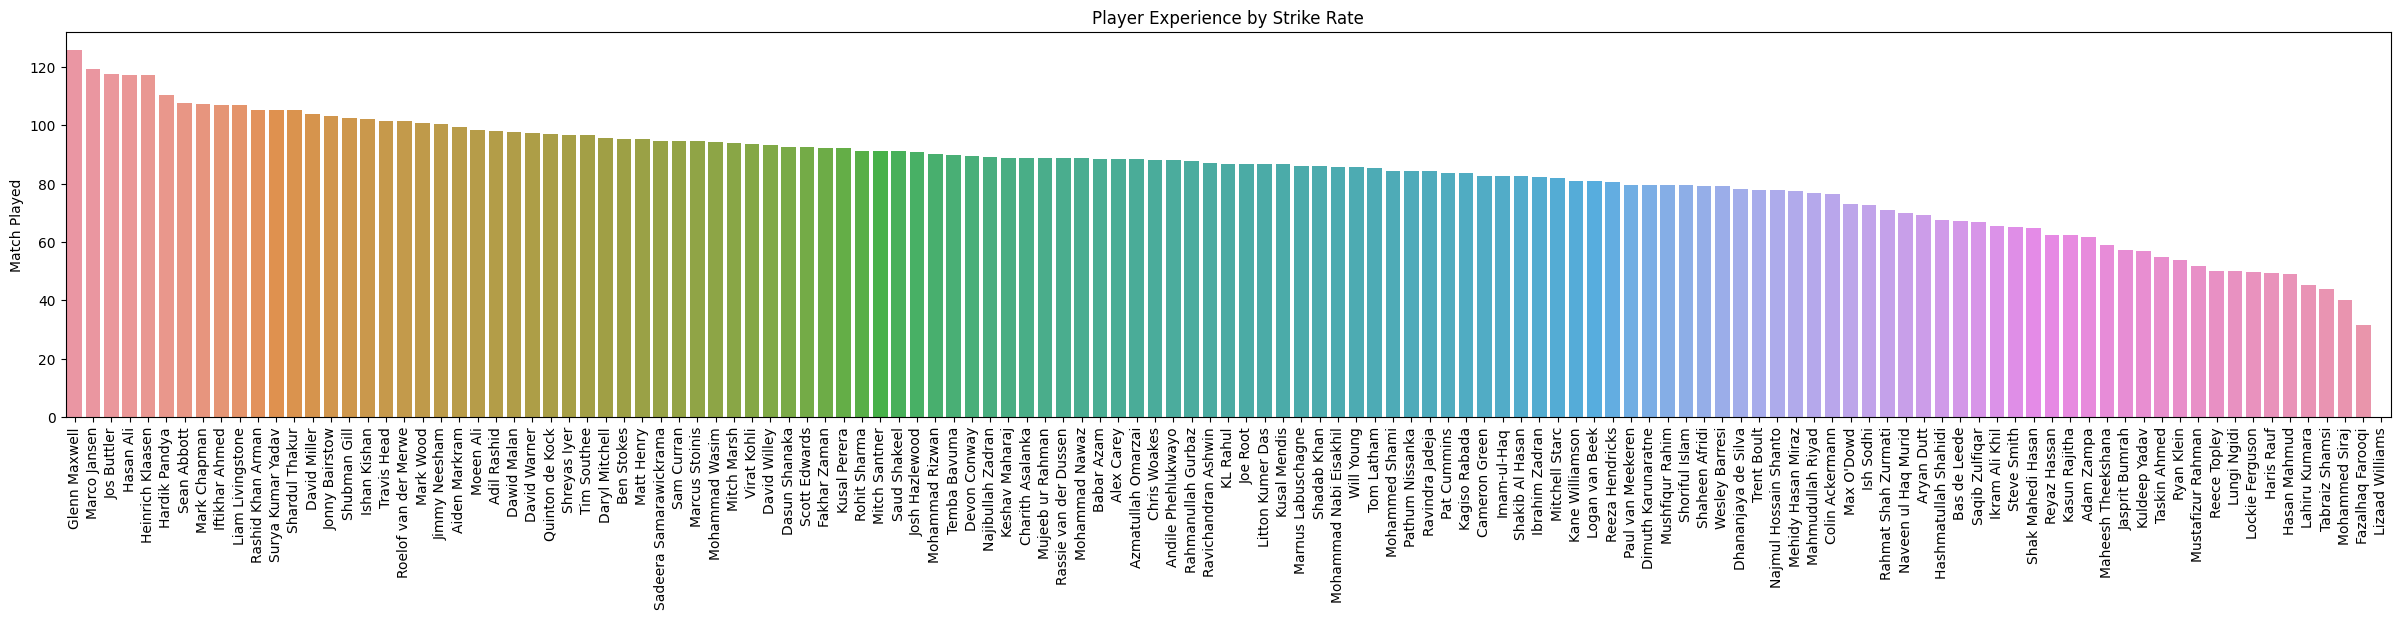

In [26]:
# Batting Strike Rate

plt.figure(figsize=(30, 5))
mat = df[["player_name", "SR"]].sort_values("SR", ascending=False)
ax = sns.barplot(x="player_name", y="SR", data=mat, order=mat["player_name"])
ax.set(xlabel="", ylabel="Match Played", title="Player Experience by Strike Rate")
plt.xticks(rotation=90)
plt.show()

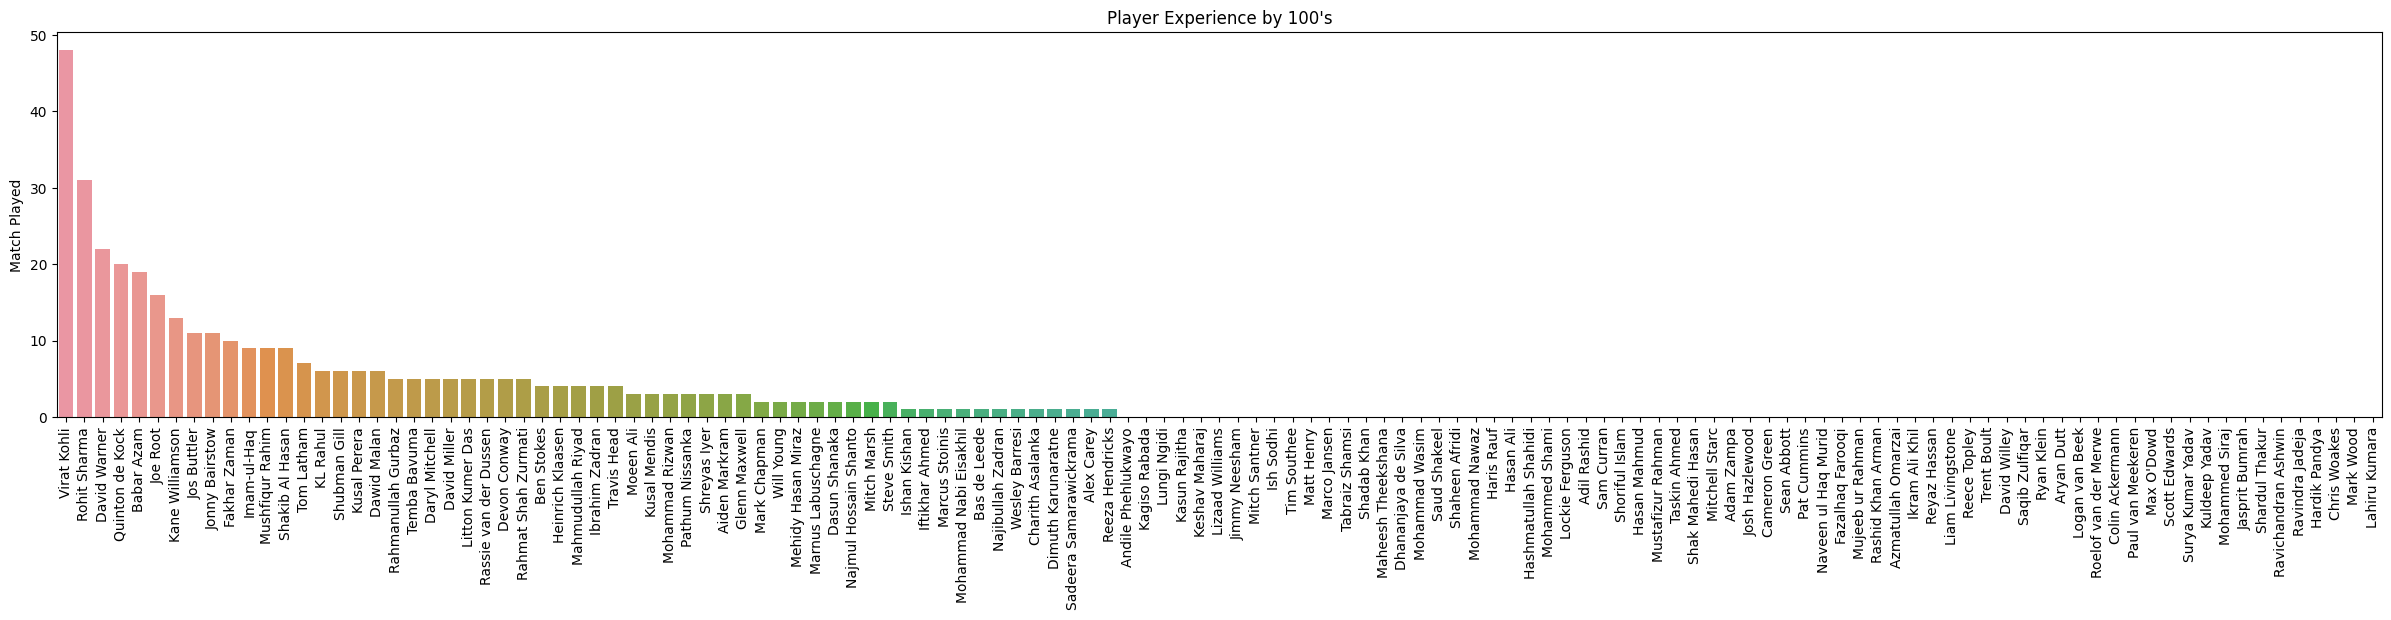

In [27]:
# By 100's

plt.figure(figsize=(30, 5))
mat = df[["player_name", "100"]].sort_values("100", ascending=False)
ax = sns.barplot(x="player_name", y="100", data=mat, order=mat["player_name"])
ax.set(xlabel="", ylabel="Match Played", title="Player Experience by 100's")
plt.xticks(rotation=90)
plt.show()

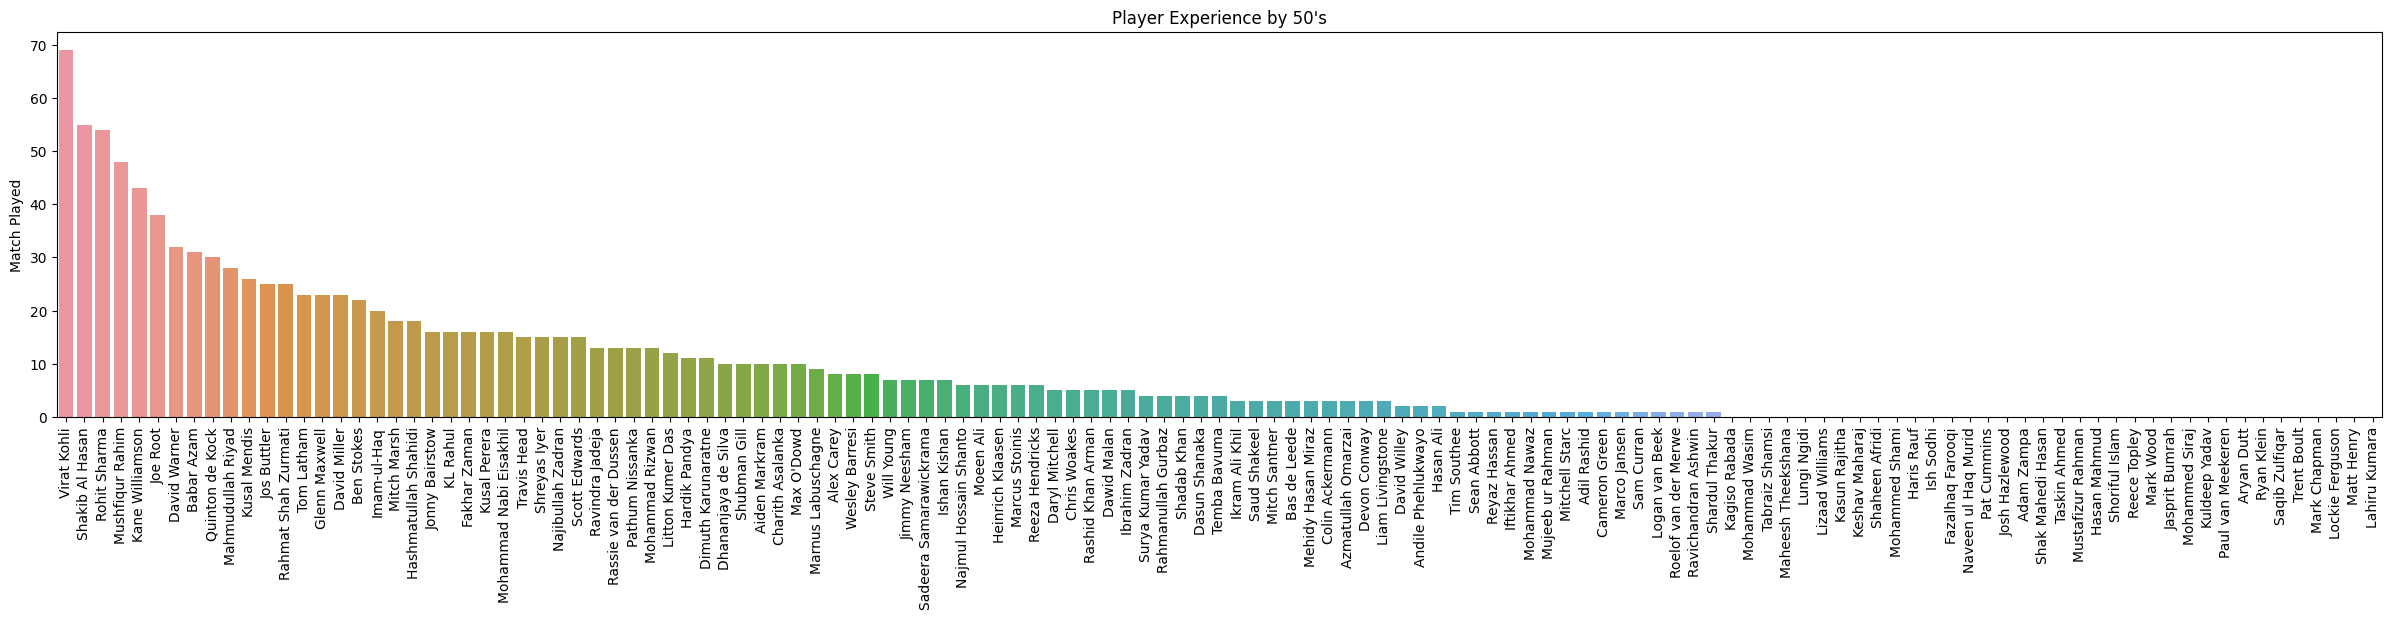

In [28]:
# By 50's

plt.figure(figsize=(30, 5))
mat = df[["player_name", "50"]].sort_values("50", ascending=False)
ax = sns.barplot(x="player_name", y="50", data=mat, order=mat["player_name"])
ax.set(xlabel="", ylabel="Match Played", title="Player Experience by 50's")
plt.xticks(rotation=90)
plt.show()

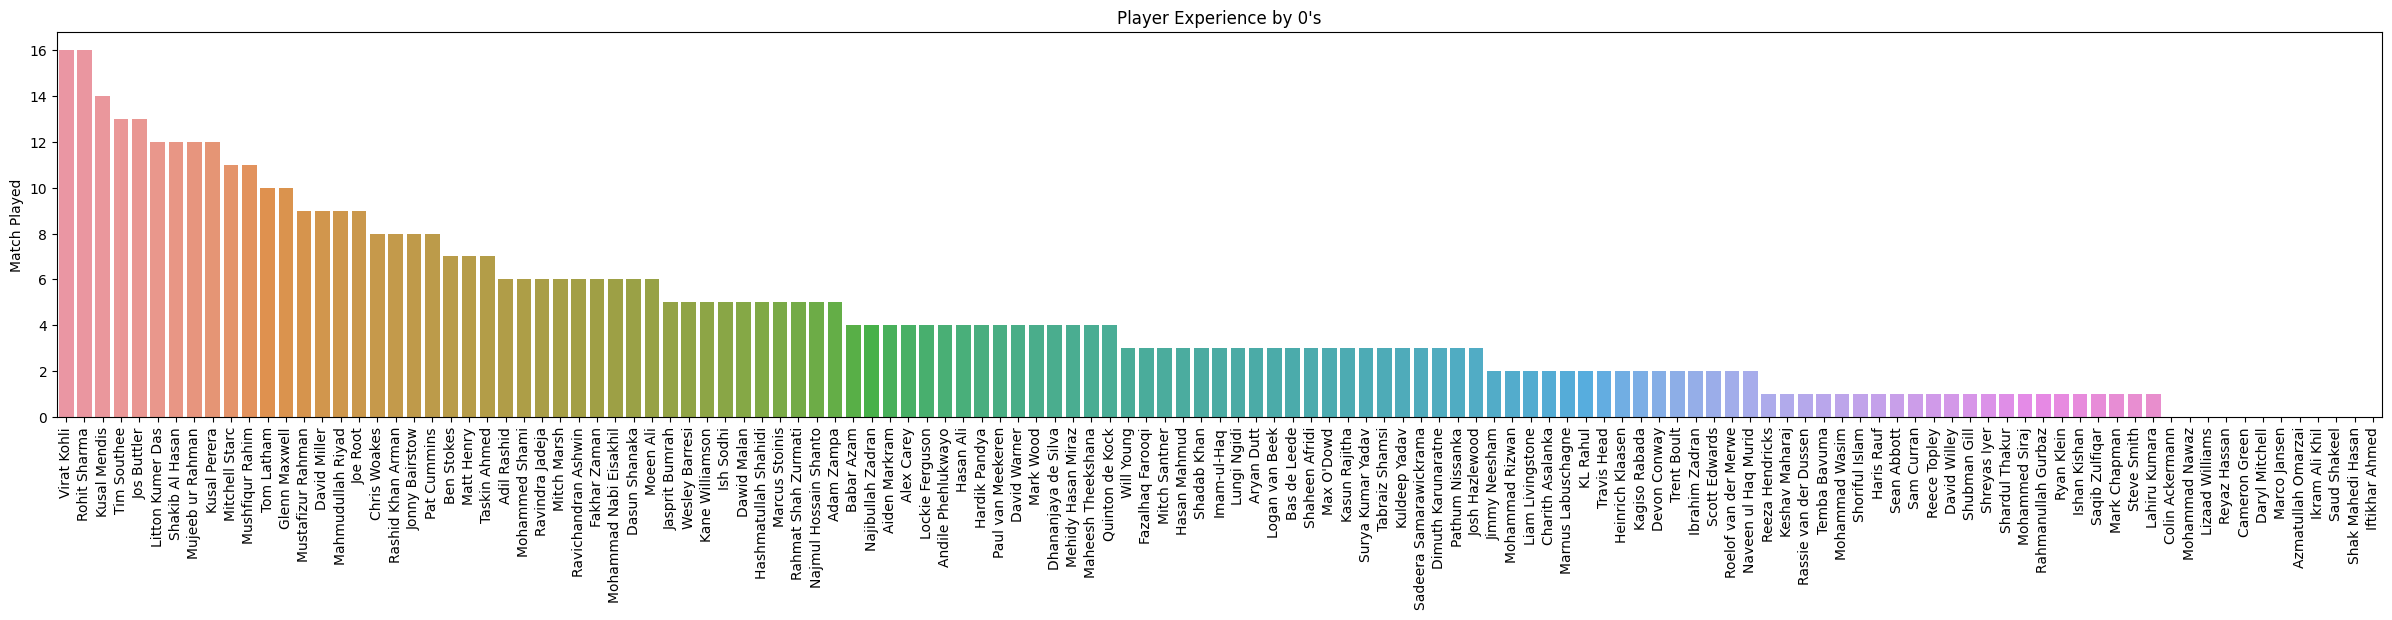

In [29]:
# By 0's

plt.figure(figsize=(30, 5))
mat = df[["player_name", "0"]].sort_values("0", ascending=False)
ax = sns.barplot(x="player_name", y="0", data=mat, order=mat["player_name"])
ax.set(xlabel="", ylabel="Match Played", title="Player Experience by 0's")
plt.xticks(rotation=90)
plt.show()

### Funny Fact

Virat Kohli, Rohit Sharma tops both the list of most runs and most number of ducks!.

# Feature Engineering

In [30]:
df["experience"] = df["end"].astype(int) - df["start"].astype(int)
df

team_name           player_name          player_role  Mat  Inns  NO  \
0    Afghanistan  Hashmatullah Shahidi     Top order Batter   70    70  11   
1    Afghanistan    Rahmanullah Gurbaz  Wicketkeeper Batter   32    32   1   
2    Afghanistan        Ibrahim Zadran       Opening Batter   25    25   2   
3    Afghanistan          Reyaz Hassan               Batter    5     4   0   
4    Afghanistan   Rahmat Shah Zurmati           Allrounder  103    99   4   
..           ...                   ...                  ...  ...   ...  ..   
141    Sri Lanka      Charith Asalanka   Batting Allrounder   47    41   5   
142    Sri Lanka   Dhananjaya de Silva           Allrounder   88    80  10   
144    Sri Lanka    Maheesh Theekshana               Bowler   32    17   6   
146    Sri Lanka         Kasun Rajitha               Bowler   32    17   7   
148    Sri Lanka         Lahiru Kumara               Bowler   28    16   6   

     Runs     HS    Ave      BF     SR  100  50  0   4s  6s start   end  \
0    2001   97.0  33.91  2962.0  67.55    0  18  5  173  12  2013  2023   
1    1182  151.0  38.12  1349.0  87.62    5   4  1  107  44  2021  2023   
2    1123  162.0  48.82  1366.0  82.21    4   5  2  119  15  2019  2023   
3     120   50.0  30.00   192.0  62.50    0   1  0   12   2  2022  2023   
4    3481  114.0  36.64  4902.0  71.01    5  25  5  300  38  2013  2023   
..    ...    ...    ...     ...    ...  ...  .. ..  ...  ..   ...   ...   
141  1443  110.0  40.08  1626.0  88.74    1  10  2  116  28  2021  2023   
142  1812   93.0  25.88  2313.0  78.33    0  10  4  180  15  2016  2023   
144   149   29.0  13.54   252.0  59.12    0   0  4    8   2  2021  2023   
146   103   33.0  10.30   165.0  62.42    0   0  3   12   1  2018  2023   
148    55   10.0   5.50   122.0  45.08    0   0  1    7   1  2017  2023   

     experience  
0            10  
1             2  
2             4  
3             1  
4            10  
..          ...  
141           2  
142           7  
144           2  
146           5  
148           6  

[127 rows x 19 columns]

# Feature Selection

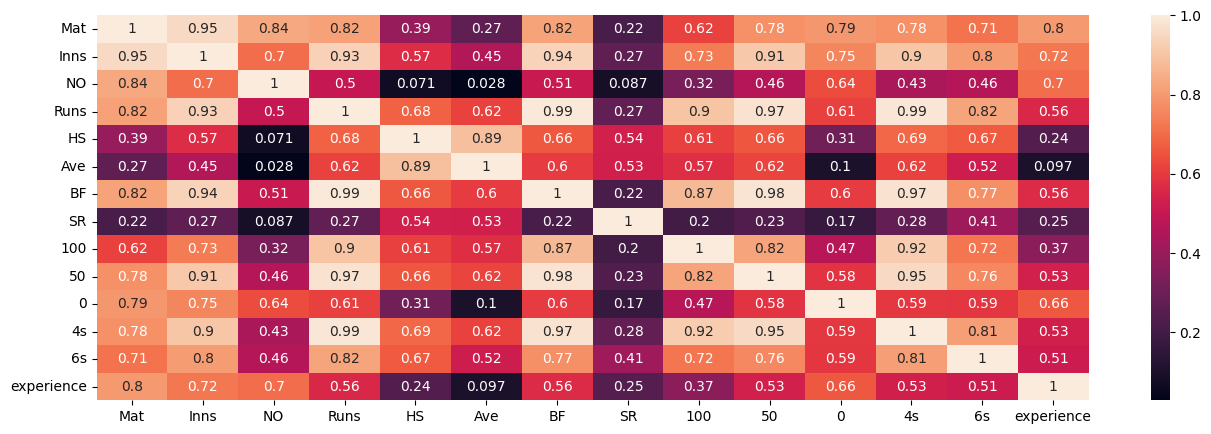

In [31]:
plt.figure(figsize=(16, 5))
sns.heatmap(df.corr(), annot=True)
plt.show()

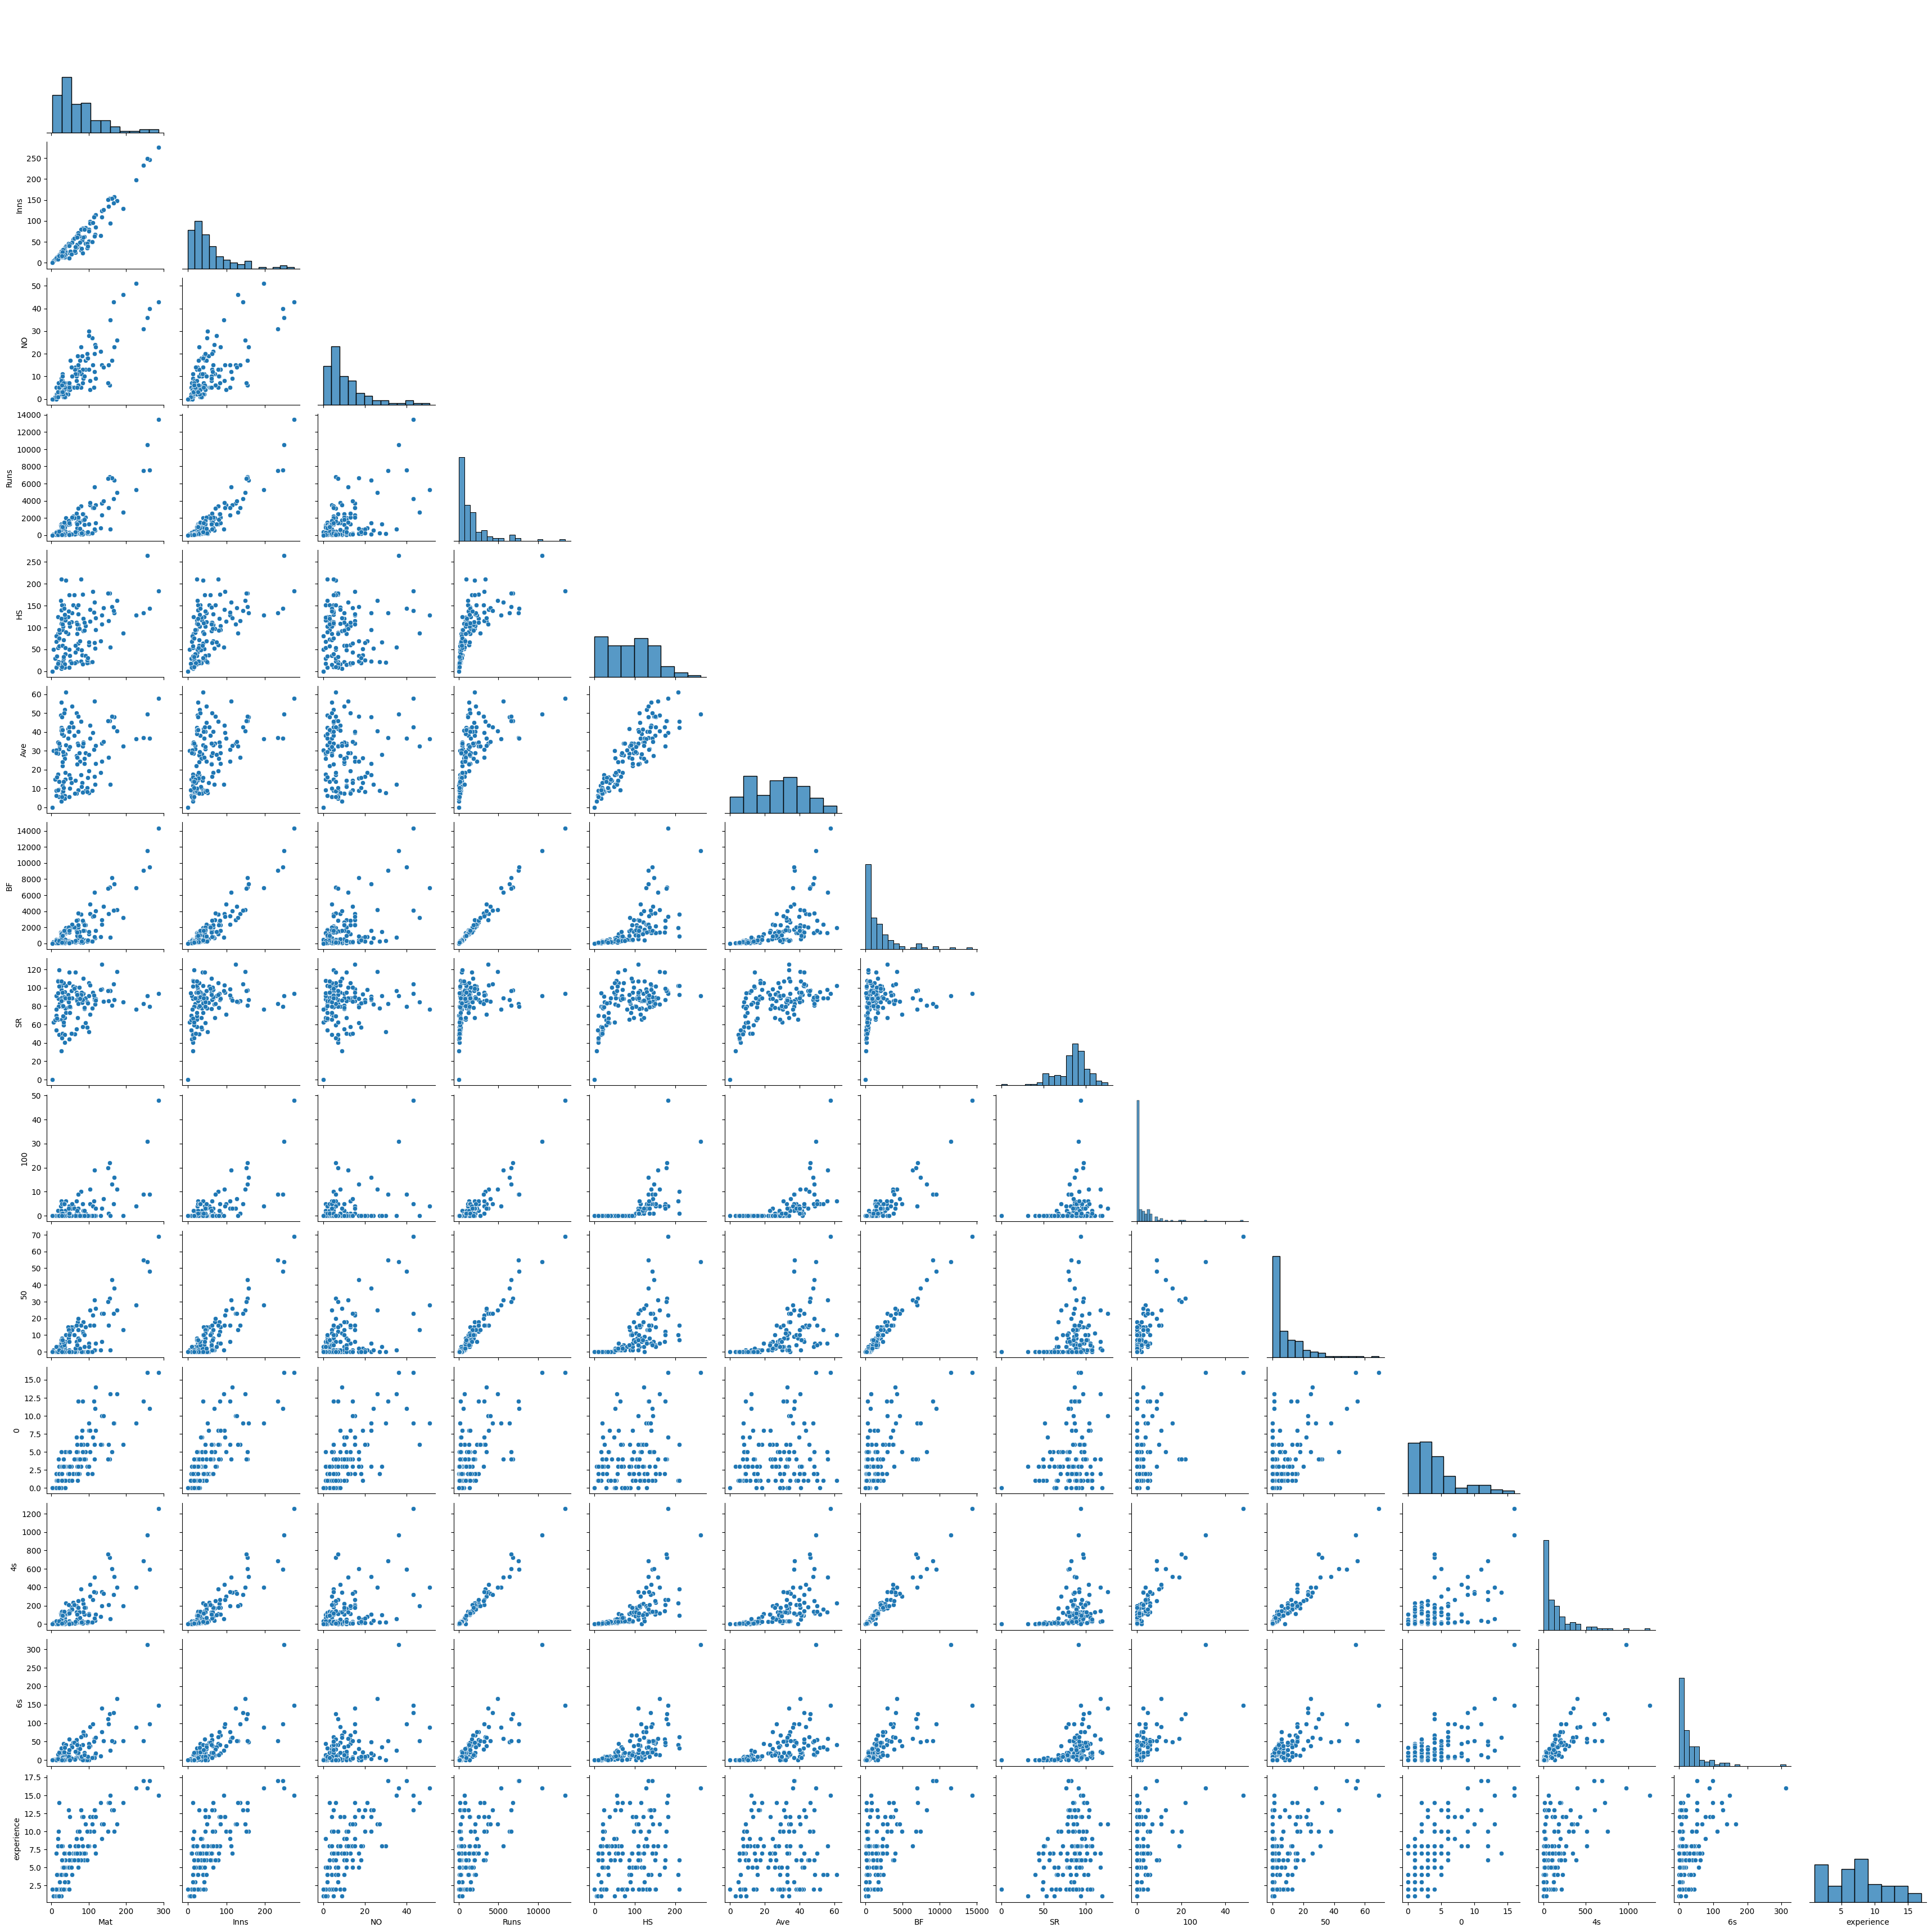

In [32]:
sns.pairplot(df, corner=True)
plt.show()

## Outlier Analysis

In [33]:
df.describe()

Mat        Inns          NO          Runs          HS  \
count  127.000000  127.000000  127.000000    127.000000  127.000000   
mean    72.362205   57.149606   11.000000   1621.094488   90.244094   
std     56.929317   52.977695   10.287919   2171.752406   56.019798   
min      2.000000    0.000000    0.000000      0.000000    0.000000   
25%     29.500000   23.500000    4.000000    210.500000   38.500000   
50%     59.000000   40.000000    7.000000    879.000000   93.000000   
75%     96.500000   70.500000   14.500000   2021.000000  132.000000   
max    287.000000  275.000000   51.000000  13437.000000  264.000000   

              Ave            BF          SR         100          50  \
count  127.000000    127.000000  127.000000  127.000000  127.000000   
mean    27.570945   1819.346457   83.615669    2.897638    8.748031   
std     14.793339   2422.142042   19.275591    6.320582   12.598166   
min      0.000000      0.000000    0.000000    0.000000    0.000000   
25%     13.940000    281.000000   77.030000    0.000000    0.000000   
50%     28.750000   1067.000000   86.890000    0.000000    4.000000   
75%     39.360000   2207.500000   94.960000    3.000000   13.000000   
max     61.240000  14350.000000  125.750000   48.000000   69.000000   

                0           4s          6s  experience  
count  127.000000   127.000000  127.000000  127.000000  
mean     4.149606   146.188976   31.047244    7.181102  
std      3.651655   202.367563   42.446205    4.112346  
min      0.000000     0.000000    0.000000    1.000000  
25%      1.000000    18.500000    5.000000    4.000000  
50%      3.000000    88.000000   16.000000    7.000000  
75%      6.000000   184.000000   43.000000   10.000000  
max     16.000000  1255.000000  312.000000   17.000000

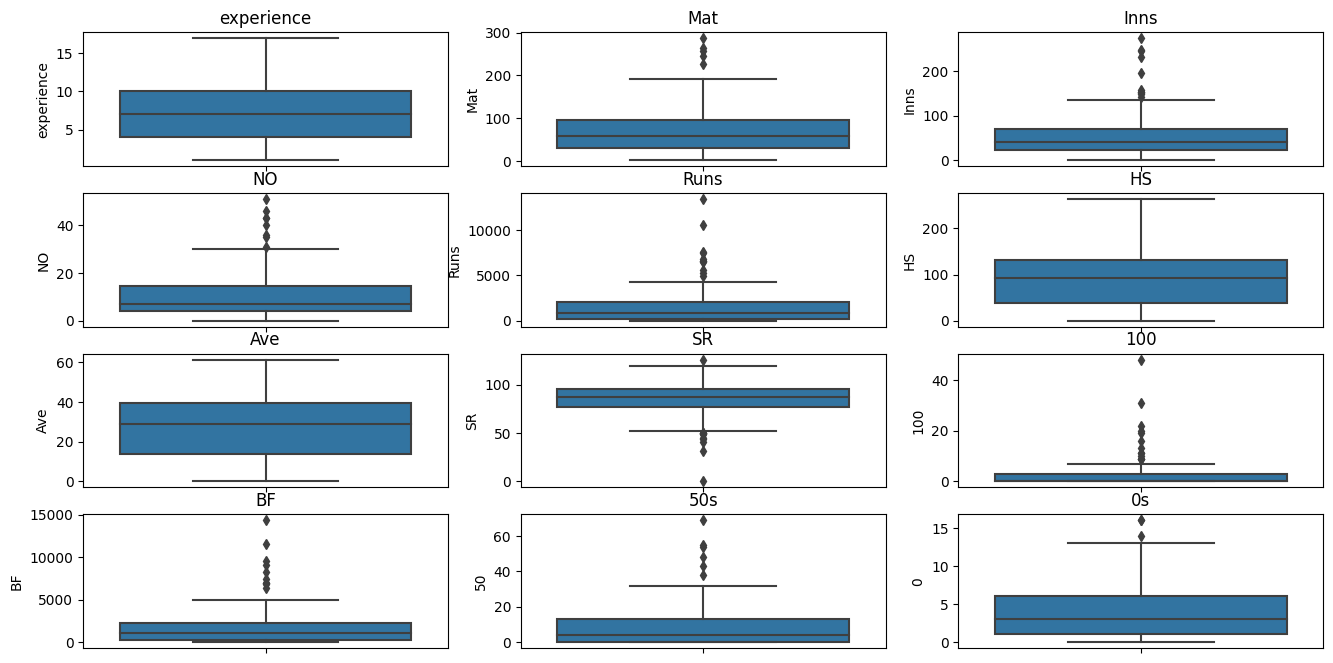

In [34]:
f, axes = plt.subplots(4, 3, figsize=(16, 8))
s = sns.boxplot(y=df.experience, ax=axes[0, 0])
axes[0, 0].set_title("experience")
s = sns.boxplot(y=df.Mat, ax=axes[0, 1])
axes[0, 1].set_title("Mat")
s = sns.boxplot(y=df.Inns, ax=axes[0, 2])
axes[0, 2].set_title("Inns")

s = sns.boxplot(y=df.NO, ax=axes[1, 0])
axes[1, 0].set_title("NO")
s = sns.boxplot(y=df.Runs, ax=axes[1, 1])
axes[1, 1].set_title("Runs")
s = sns.boxplot(y=df.HS, ax=axes[1, 2])
axes[1, 2].set_title("HS")

s = sns.boxplot(y=df.Ave, ax=axes[2, 0])
axes[2, 0].set_title("Ave")
s = sns.boxplot(y=df.SR, ax=axes[2, 1])
axes[2, 1].set_title("SR")
s = sns.boxplot(y=df["100"], ax=axes[2, 2])
axes[2, 2].set_title("100")
s = sns.boxplot(y=df.BF, ax=axes[3, 0])
axes[3, 0].set_title("BF")
s = sns.boxplot(y=df["50"], ax=axes[3, 1])
axes[3, 1].set_title("50s")
s = sns.boxplot(y=df["0"], ax=axes[3, 2])
axes[3, 2].set_title("0s")
plt.show()

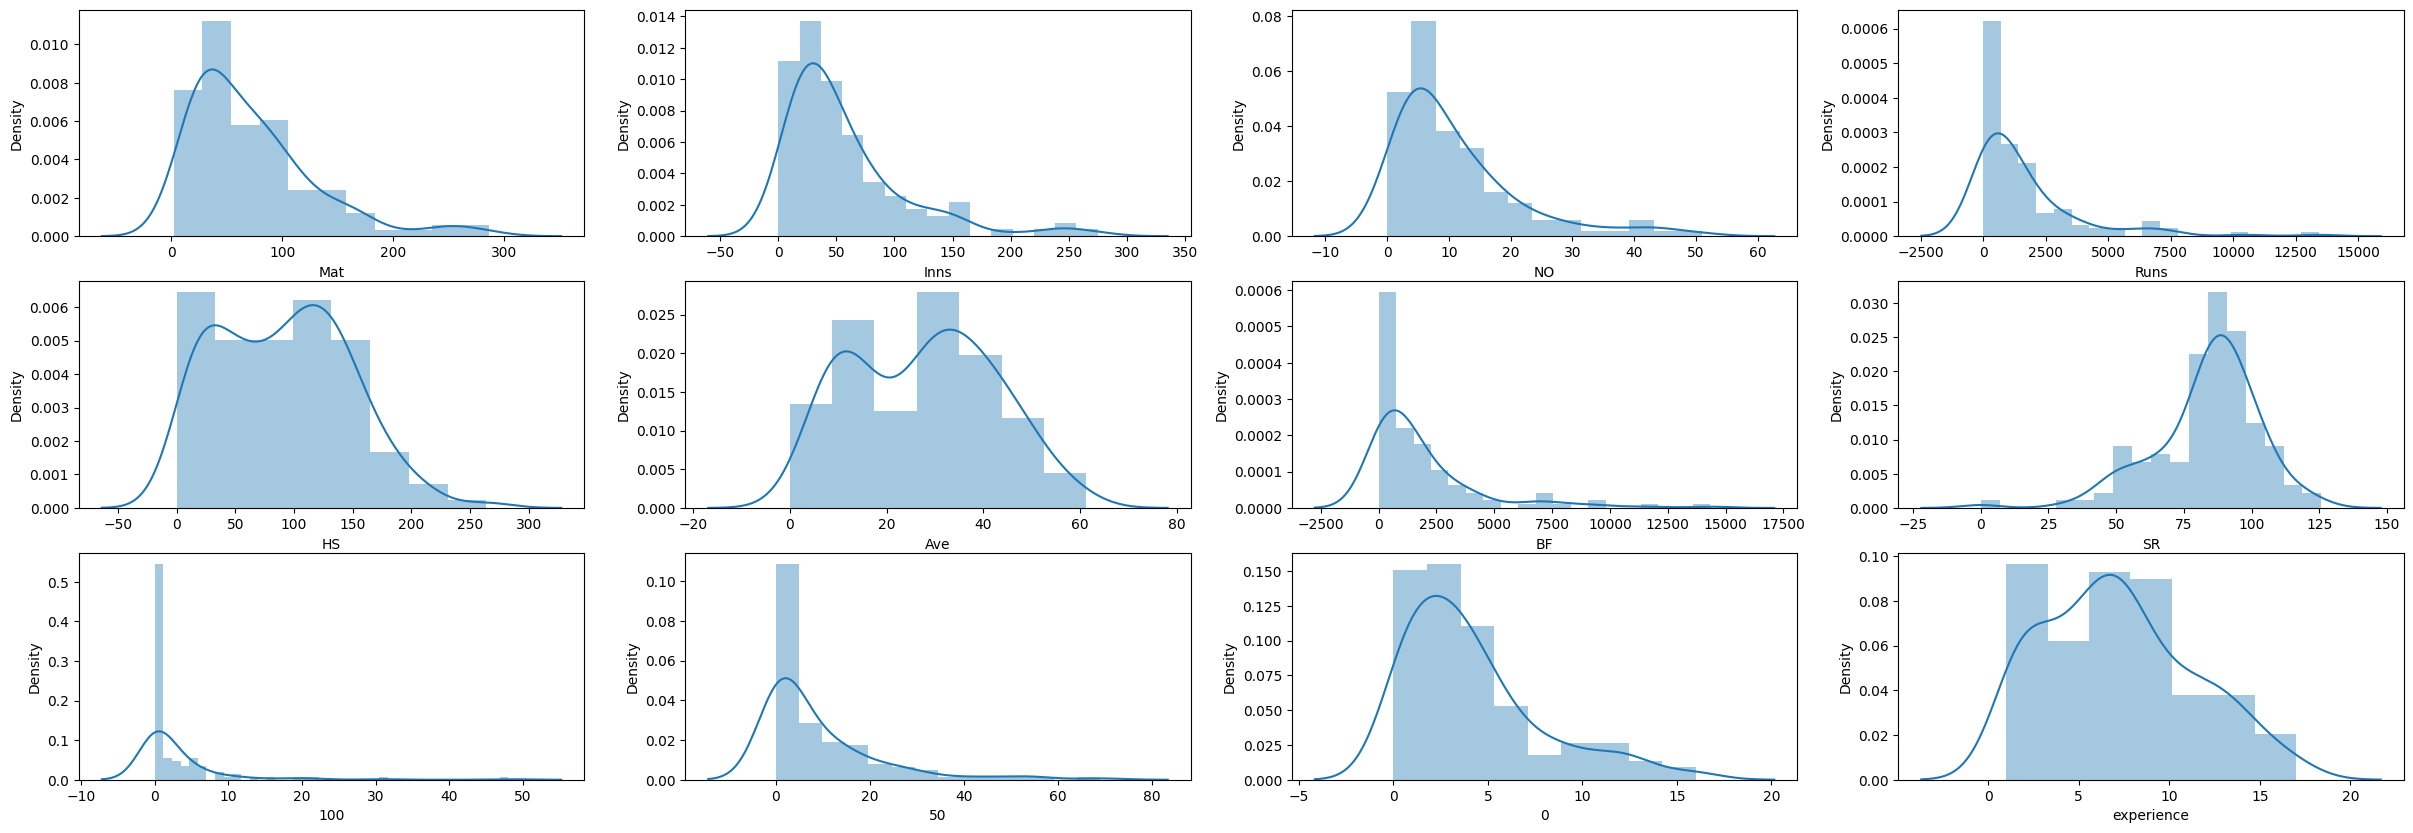

In [35]:
# Plot histogram for each continous variables

plt.figure(figsize=(30, 10))
features = [
    "Mat",
    "Inns",
    "NO",
    "Runs",
    "HS",
    "Ave",
    "BF",
    "SR",
    "100",
    "50",
    "0",
    "experience",
]
for i in enumerate(features):
    plt.subplot(3, 4, i[0] + 1)
    sns.distplot(df[i[1]])

### Percentile Capping

In [36]:
features = [
    "Mat",
    "Inns",
    "NO",
    "Runs",
    "HS",
    "Ave",
    "BF",
    "SR",
    "100",
    "50",
    "0",
    "experience",
]
for i in enumerate(features):
    Q3 = df[i[1]].quantile(0.99)
    Q1 = df[i[1]].quantile(0.01)
    df[i[1]][df[i[1]] <= Q1] = Q1
    df[i[1]][df[i[1]] >= Q3] = Q3

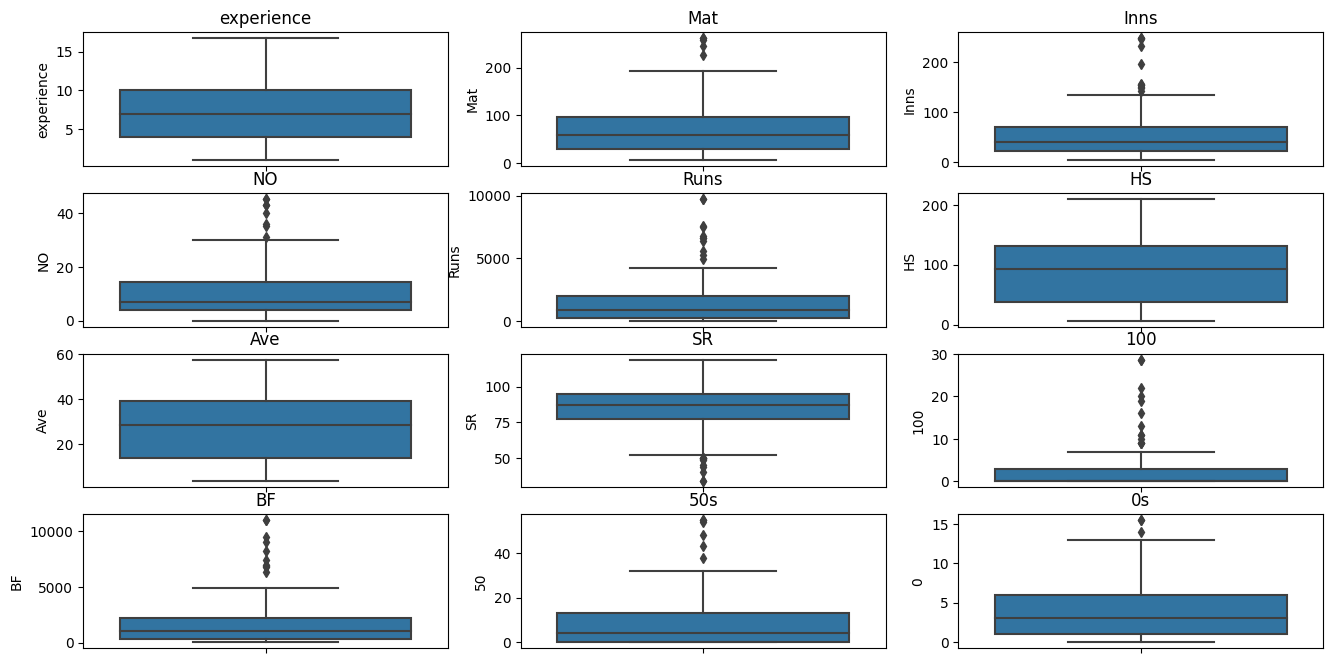

In [37]:
f, axes = plt.subplots(4, 3, figsize=(16, 8))
s = sns.boxplot(y=df.experience, ax=axes[0, 0])
axes[0, 0].set_title("experience")
s = sns.boxplot(y=df.Mat, ax=axes[0, 1])
axes[0, 1].set_title("Mat")
s = sns.boxplot(y=df.Inns, ax=axes[0, 2])
axes[0, 2].set_title("Inns")

s = sns.boxplot(y=df.NO, ax=axes[1, 0])
axes[1, 0].set_title("NO")
s = sns.boxplot(y=df.Runs, ax=axes[1, 1])
axes[1, 1].set_title("Runs")
s = sns.boxplot(y=df.HS, ax=axes[1, 2])
axes[1, 2].set_title("HS")

s = sns.boxplot(y=df.Ave, ax=axes[2, 0])
axes[2, 0].set_title("Ave")
s = sns.boxplot(y=df.SR, ax=axes[2, 1])
axes[2, 1].set_title("SR")
s = sns.boxplot(y=df["100"], ax=axes[2, 2])
axes[2, 2].set_title("100")
s = sns.boxplot(y=df.BF, ax=axes[3, 0])
axes[3, 0].set_title("BF")
s = sns.boxplot(y=df["50"], ax=axes[3, 1])
axes[3, 1].set_title("50s")
s = sns.boxplot(y=df["0"], ax=axes[3, 2])
axes[3, 2].set_title("0s")
plt.show()

In [38]:
df_cleaned = df.copy()
df_cleaned

team_name           player_name          player_role    Mat   Inns  \
0    Afghanistan  Hashmatullah Shahidi     Top order Batter   70.0  70.00   
1    Afghanistan    Rahmanullah Gurbaz  Wicketkeeper Batter   32.0  32.00   
2    Afghanistan        Ibrahim Zadran       Opening Batter   25.0  25.00   
3    Afghanistan          Reyaz Hassan               Batter    6.3   5.04   
4    Afghanistan   Rahmat Shah Zurmati           Allrounder  103.0  99.00   
..           ...                   ...                  ...    ...    ...   
141    Sri Lanka      Charith Asalanka   Batting Allrounder   47.0  41.00   
142    Sri Lanka   Dhananjaya de Silva           Allrounder   88.0  80.00   
144    Sri Lanka    Maheesh Theekshana               Bowler   32.0  17.00   
146    Sri Lanka         Kasun Rajitha               Bowler   32.0  17.00   
148    Sri Lanka         Lahiru Kumara               Bowler   28.0  16.00   

       NO    Runs     HS    Ave      BF     SR  100    50    0   4s  6s start  \
0    11.0  2001.0   97.0  33.91  2962.0  67.55  0.0  18.0  5.0  173  12  2013   
1     1.0  1182.0  151.0  38.12  1349.0  87.62  5.0   4.0  1.0  107  44  2021   
2     2.0  1123.0  162.0  48.82  1366.0  82.21  4.0   5.0  2.0  119  15  2019   
3     0.0   120.0   50.0  30.00   192.0  62.50  0.0   1.0  0.0   12   2  2022   
4     4.0  3481.0  114.0  36.64  4902.0  71.01  5.0  25.0  5.0  300  38  2013   
..    ...     ...    ...    ...     ...    ...  ...   ...  ...  ...  ..   ...   
141   5.0  1443.0  110.0  40.08  1626.0  88.74  1.0  10.0  2.0  116  28  2021   
142  10.0  1812.0   93.0  25.88  2313.0  78.33  0.0  10.0  4.0  180  15  2016   
144   6.0   149.0   29.0  13.54   252.0  59.12  0.0   0.0  4.0    8   2  2021   
146   7.0   103.0   33.0  10.30   165.0  62.42  0.0   0.0  3.0   12   1  2018   
148   6.0    55.0   10.0   5.50   122.0  45.08  0.0   0.0  1.0    7   1  2017   

      end  experience  
0    2023        10.0  
1    2023         2.0  
2    2023         4.0  
3    2023         1.0  
4    2023        10.0  
..    ...         ...  
141  2023         2.0  
142  2023         7.0  
144  2023         2.0  
146  2023         5.0  
148  2023         6.0  

[127 rows x 19 columns]

In [39]:
df_cleaned.drop(["start", "end"], axis=1, inplace=True)
df_cleaned.drop(["player_name"], axis=1, inplace=True)
df_cleaned.drop(["team_name"], axis=1, inplace=True)
df_cleaned.drop(["player_role"], axis=1, inplace=True)
df_cleaned

Mat   Inns    NO    Runs     HS    Ave      BF     SR  100    50    0  \
0     70.0  70.00  11.0  2001.0   97.0  33.91  2962.0  67.55  0.0  18.0  5.0   
1     32.0  32.00   1.0  1182.0  151.0  38.12  1349.0  87.62  5.0   4.0  1.0   
2     25.0  25.00   2.0  1123.0  162.0  48.82  1366.0  82.21  4.0   5.0  2.0   
3      6.3   5.04   0.0   120.0   50.0  30.00   192.0  62.50  0.0   1.0  0.0   
4    103.0  99.00   4.0  3481.0  114.0  36.64  4902.0  71.01  5.0  25.0  5.0   
..     ...    ...   ...     ...    ...    ...     ...    ...  ...   ...  ...   
141   47.0  41.00   5.0  1443.0  110.0  40.08  1626.0  88.74  1.0  10.0  2.0   
142   88.0  80.00  10.0  1812.0   93.0  25.88  2313.0  78.33  0.0  10.0  4.0   
144   32.0  17.00   6.0   149.0   29.0  13.54   252.0  59.12  0.0   0.0  4.0   
146   32.0  17.00   7.0   103.0   33.0  10.30   165.0  62.42  0.0   0.0  3.0   
148   28.0  16.00   6.0    55.0   10.0   5.50   122.0  45.08  0.0   0.0  1.0   

      4s  6s  experience  
0    173  12        10.0  
1    107  44         2.0  
2    119  15         4.0  
3     12   2         1.0  
4    300  38        10.0  
..   ...  ..         ...  
141  116  28         2.0  
142  180  15         7.0  
144    8   2         2.0  
146   12   1         5.0  
148    7   1         6.0  

[127 rows x 14 columns]

## Hopkins Statistics Test

The Hopkins statistic (introduced by Brian Hopkins and John Gordon Skellam) is a way of measuring the cluster tendency of a data set.It acts as a statistical hypothesis test where the null hypothesis is that the data is generated by a Poisson point process and are thus uniformly randomly distributed. A value close to 1 tends to indicate the data is highly clustered, random data will tend to result in values around 0.5, and uniformly distributed data will tend to result in values close to 0.

- If the value is between {0.01, ...,0.3}, the data is regularly spaced.
- If the value is around 0.5, it is random.
- If the value is between {0.7, ..., 0.99}, it has a high tendency to cluster.

In [40]:
def hopkins(X):
    d = X.shape[1]
    n = len(X)
    m = int(0.1 * n)
    nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)

    rand_X = sample(range(0, n, 1), m)

    ujd = []
    wjd = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(
            uniform(np.amin(X, axis=0), np.amax(X, axis=0), d).reshape(1, -1),
            2,
            return_distance=True,
        )
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(
            X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True
        )
        wjd.append(w_dist[0][1])

    HS = sum(ujd) / (sum(ujd) + sum(wjd))
    if isnan(HS):
        print(ujd, wjd)
        HS = 0

    return HS

In [41]:
hopkins_score = round(hopkins(df_cleaned), 2)
print("{} is a good Hopkins score for Clustering.".format(hopkins_score))

0.98 is a good Hopkins score for Clustering.


## Rescaling the Features

In [42]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_cleaned)
df_scaled

array([[-0.03923464,  0.25099213,  0.00513458, ...,  0.13301147,
        -0.45051564,  0.69082201],
       [-0.71916269, -0.48157676, -0.98890813, ..., -0.1944194 ,
         0.30636553, -1.26687955],
       [-0.84441259, -0.61652366, -0.88950386, ..., -0.13488652,
        -0.37955803, -0.77745416],
       ...,
       [-0.71916269, -0.77074869, -0.49188678, ..., -0.68556571,
        -0.68704101, -1.26687955],
       [-0.71916269, -0.77074869, -0.3924825 , ..., -0.66572141,
        -0.71069354, -0.53274147],
       [-0.79073406, -0.79002682, -0.49188678, ..., -0.69052678,
        -0.71069354, -0.28802877]])

In [43]:
df_final = pd.DataFrame(
    df_scaled,
    columns=[
        "Mat",
        "Inns",
        "NO",
        "Runs",
        "HS",
        "Ave",
        "BF",
        "SR",
        "100",
        "50",
        "0",
        "6s",
        "4s",
        "experience",
    ],
)
df_final.head()

Mat      Inns        NO      Runs        HS       Ave        BF  \
0 -0.039235  0.250992  0.005135  0.207506  0.130555  0.434025  0.515936   
1 -0.719163 -0.481577 -0.988908 -0.202192  1.119933  0.722203 -0.193654   
2 -0.844413 -0.616524 -0.889504 -0.231706  1.321473  1.454626 -0.186175   
3 -1.179009 -1.001315 -1.088312 -0.733448 -0.730570  0.166383 -0.702640   
4  0.551229  0.810058 -0.690695  0.947863  0.442026  0.620896  1.369378   

         SR       100        50         0        6s        4s  experience  
0 -0.901098 -0.516987  0.776938  0.237765  0.133011 -0.450516    0.690822  
1  0.209043  0.430942 -0.384367 -0.869945 -0.194419  0.306366   -1.266880  
2 -0.090203  0.241356 -0.301417 -0.593018 -0.134887 -0.379558   -0.777454  
3 -1.180430 -0.516987 -0.633218 -1.146873 -0.665721 -0.687041   -1.511592  
4 -0.709713  0.430942  1.357591  0.237765  0.763068  0.164450    0.690822

# Model Building

## K-Means Clustering

### Finding the Optimal Number of Clusters

#### Elbow Curve to get the right number of Clusters

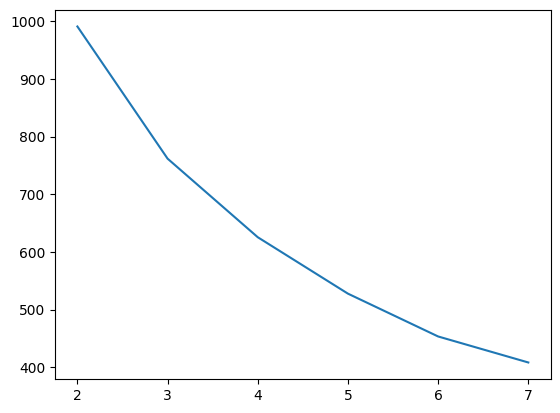

In [44]:
# Elbow curve method to find the ideal number of clusters.
clusters = list(range(2, 8))
ssd = []
for num_clusters in clusters:
    model_clus = KMeans(n_clusters=num_clusters, max_iter=150, random_state=50)
    model_clus.fit(df_final)
    ssd.append(model_clus.inertia_)

plt.plot(clusters, ssd)

#### Silhouette Analysis

Silhouette Score = (p - q) / max(p, q)

- p is the mean distance to the points in the nearest cluster that the data point is not a part of
- q is the mean intra-cluster distance to all the points in its own cluster.
- The value of the silhouette score range lies between -1 to 1.
- A score closer to 1 indicates that the data point is very similar to other data points in the cluster,
- A score closer to -1 indicates that the data point is not similar to the data points in its cluster.


In [45]:
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

graph = []

for num_clusters in range_n_clusters:
    # intialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50, random_state=100)
    kmeans.fit(df_final)

    cluster_labels = kmeans.labels_

    # silhouette score
    silhouette_avg = silhouette_score(df_final, cluster_labels)
    print(
        "For n_clusters = {0}, the silhouette score is {1}".format(
            num_clusters, silhouette_avg
        )
    )

    graph.append([num_clusters, silhouette_avg])

For n_clusters = 2, the silhouette score is 0.496025045531021
For n_clusters = 3, the silhouette score is 0.27421644893325947
For n_clusters = 4, the silhouette score is 0.2745618963023669
For n_clusters = 5, the silhouette score is 0.2898551639072828
For n_clusters = 6, the silhouette score is 0.2757890607978036
For n_clusters = 7, the silhouette score is 0.3086511789720869
For n_clusters = 8, the silhouette score is 0.2617954688963246


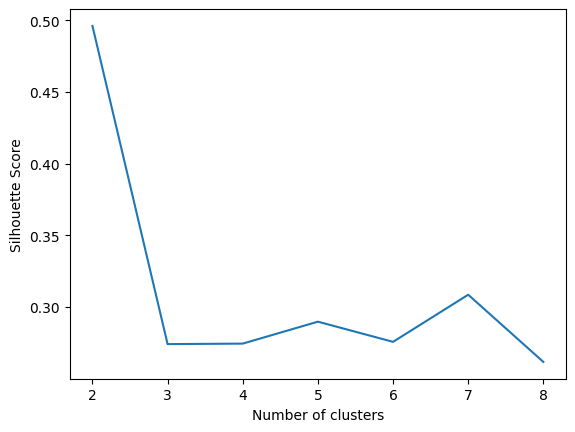

In [46]:
# Plot graph

df_sil = pd.DataFrame(graph)
plt.plot(df_sil[0], df_sil[1])
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette Score")
plt.show()

In [47]:
# K = 4, as the avg distance falls sharply from 2 to 4

kmeans = KMeans(n_clusters=4, max_iter=50, random_state=100)
kmeans.fit(df_final)


KMeans(max_iter=50, n_clusters=4, random_state=100)

In [48]:
df['cluster_id'] = kmeans.labels_
df.head()

team_name           player_name          player_role    Mat   Inns    NO  \
0  Afghanistan  Hashmatullah Shahidi     Top order Batter   70.0  70.00  11.0   
1  Afghanistan    Rahmanullah Gurbaz  Wicketkeeper Batter   32.0  32.00   1.0   
2  Afghanistan        Ibrahim Zadran       Opening Batter   25.0  25.00   2.0   
3  Afghanistan          Reyaz Hassan               Batter    6.3   5.04   0.0   
4  Afghanistan   Rahmat Shah Zurmati           Allrounder  103.0  99.00   4.0   

     Runs     HS    Ave      BF     SR  100    50    0   4s  6s start   end  \
0  2001.0   97.0  33.91  2962.0  67.55  0.0  18.0  5.0  173  12  2013  2023   
1  1182.0  151.0  38.12  1349.0  87.62  5.0   4.0  1.0  107  44  2021  2023   
2  1123.0  162.0  48.82  1366.0  82.21  4.0   5.0  2.0  119  15  2019  2023   
3   120.0   50.0  30.00   192.0  62.50  0.0   1.0  0.0   12   2  2022  2023   
4  3481.0  114.0  36.64  4902.0  71.01  5.0  25.0  5.0  300  38  2013  2023   

   experience  cluster_id  
0        10.0           1  
1         2.0           1  
2         4.0           1  
3         1.0           0  
4        10.0           2

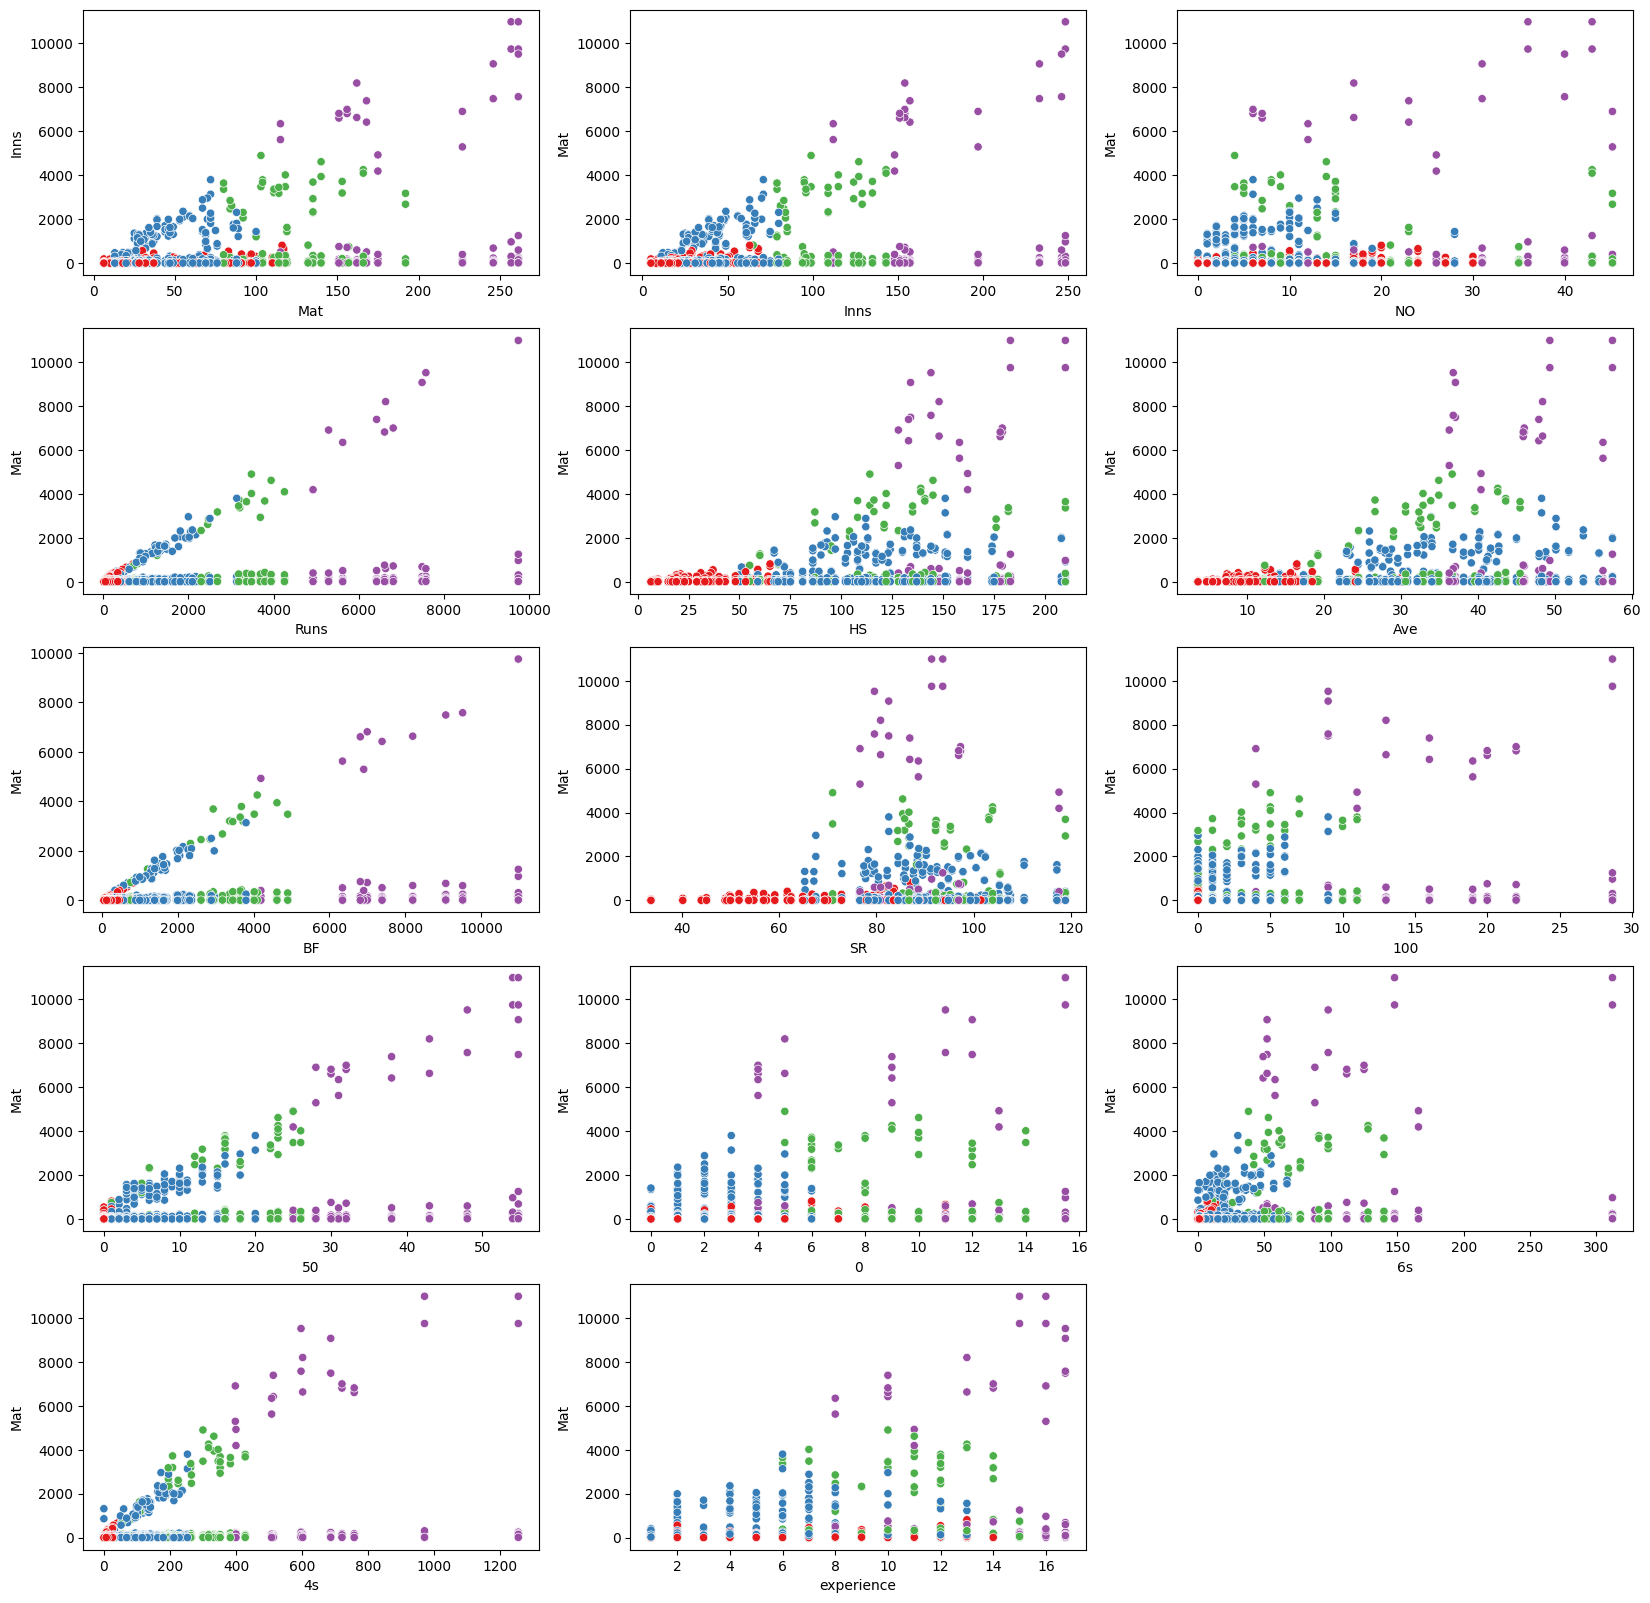

In [49]:
# Plot all parameters with respect to cluster id

params = ['Mat', 'Inns', 'NO', 'Runs', 'HS', 'Ave', 'BF', 'SR', '100', '50', '0', '6s', '4s', 'experience']
# Scatter pair plot
plt.figure(figsize=(20, 20))
for i in enumerate(params):
    for j in enumerate(params):
        if i != j:
            plt.subplot(5, 3, i[0] + 1)
            sns.scatterplot(x=i[1], y=j[1], hue=df['cluster_id'], data=df, palette='Set1', legend=False)
plt.show()

In [50]:
df['cluster_id'].value_counts()

1    55
0    42
2    19
3    11
Name: cluster_id, dtype: int64

In [51]:
df[df['cluster_id'] == 0]

team_name           player_name         player_role    Mat   Inns  \
3     Afghanistan          Reyaz Hassan              Batter    6.3   5.04   
10    Afghanistan      Mujeeb ur Rahman              Bowler   72.0  39.00   
12    Afghanistan      Fazalhaq Farooqi              Bowler   26.0  14.00   
14    Afghanistan   Naveen ul Haq Murid              Bowler   13.0   9.00   
15      Australia           Pat Cummins              Bowler   83.0  54.00   
21      Australia        Josh Hazlewood              Bowler   80.0  30.00   
28      Australia            Adam Zampa              Bowler   91.0  46.00   
29      Australia        Mitchell Starc              Bowler  117.0  68.00   
39     Bangladesh     Shak Mahedi Hasan          Allrounder   10.0   9.00   
40     Bangladesh          Taskin Ahmed              Bowler   68.0  37.00   
41     Bangladesh     Mustafizur Rahman              Bowler  100.0  51.00   
42     Bangladesh          Hasan Mahmud              Bowler   20.0  12.00   
43     Bangladesh        Shoriful Islam              Bowler   29.0  18.00   
56        England          Reece Topley              Bowler   29.0  14.00   
58        England             Mark Wood              Bowler   65.0  25.00   
67          India   Ravichandran Ashwin  Bowling Allrounder  116.0  63.00   
69          India        Jasprit Bumrah              Bowler   84.0  24.00   
70          India        Mohammed Siraj              Bowler   36.0  13.00   
71          India         Kuldeep Yadav              Bowler   96.0  35.00   
72          India        Mohammed Shami              Bowler   96.0  46.00   
80    Netherlands     Paul van Meekeren              Bowler   19.0  16.00   
82    Netherlands  Roelof van der Merwe  Bowling Allrounder   21.0  13.00   
83    Netherlands        Logan van Beek              Bowler   30.0  29.00   
84    Netherlands            Aryan Dutt              Bowler   31.0  24.00   
85    Netherlands            Ryan Klein              Bowler   13.0   9.00   
87    Netherlands        Saqib Zulfiqar  Bowling Allrounder   14.0  14.00   
91    New Zealand           Trent Boult              Bowler  110.0  50.00   
94    New Zealand       Lockie Ferguson              Bowler   63.0  29.00   
95    New Zealand            Matt Henry              Bowler   81.0  34.00   
102   New Zealand             Ish Sodhi              Bowler   49.0  24.00   
114      Pakistan        Mohammad Nawaz          Allrounder   37.0  28.00   
116      Pakistan            Haris Rauf              Bowler   35.0  14.00   
118      Pakistan        Shaheen Afridi              Bowler   51.0  28.00   
119      Pakistan        Mohammad Wasim  Bowling Allrounder   18.0   8.00   
127  South Africa        Keshav Maharaj              Bowler   37.0  19.00   
130  South Africa           Lungi Ngidi              Bowler   53.0  21.00   
131  South Africa         Kagiso Rabada              Bowler   97.0  40.00   
132  South Africa        Tabraiz Shamsi              Bowler   48.0  11.00   
134  South Africa       Lizaad Williams              Bowler    6.3   5.04   
144     Sri Lanka    Maheesh Theekshana              Bowler   32.0  17.00   
146     Sri Lanka         Kasun Rajitha              Bowler   32.0  17.00   
148     Sri Lanka         Lahiru Kumara              Bowler   28.0  16.00   

       NO    Runs     HS      Ave     BF        SR  100   50     0  4s  6s  \
3     0.0  120.00  50.00  30.0000  192.0   62.5000  0.0  1.0   0.0  12   2   
10   14.0  228.00  64.00   9.1200  257.0   88.7100  0.0  1.0  12.0  25   8   
12    9.0   17.56   6.52   3.5926   51.0   33.6684  0.0  0.0   3.0   2   0   
14    5.0   35.00  10.00   8.7500   50.0   70.0000  0.0  0.0   2.0   5   0   
15   19.0  456.00  37.00  13.0200  545.0   83.6600  0.0  0.0   8.0  35  11   
21   23.0  120.00  23.00  17.1400  132.0   90.9000  0.0  0.0   3.0  13   3   
28   17.0  256.00  36.00   8.8200  415.0   61.6800  0.0  0.0   5.0  22   1   
29   24.0  542.00  52.00  12.3100  661.0   81.9900  0.0  1.0  11.0  40  

In [52]:
df[df['cluster_id'] == 1]

team_name             player_name          player_role    Mat  Inns  \
0     Afghanistan    Hashmatullah Shahidi     Top order Batter   70.0  70.0   
1     Afghanistan      Rahmanullah Gurbaz  Wicketkeeper Batter   32.0  32.0   
2     Afghanistan          Ibrahim Zadran       Opening Batter   25.0  25.0   
7     Afghanistan          Ikram Ali Khil  Wicketkeeper Batter   18.0  15.0   
8     Afghanistan      Azmatullah Omarzai           Allrounder   19.0  13.0   
16      Australia             Steve Smith       Opening Batter   28.0  24.0   
17      Australia              Alex Carey  Wicketkeeper Batter   72.0  66.0   
19      Australia             Sean Abbott   Bowling Allrounder   17.0  14.0   
20      Australia           Cameron Green   Batting Allrounder   22.0  19.0   
22      Australia             Travis Head  Middle order Batter   59.0  56.0   
23      Australia      Marnus Labuschagne               Batter   44.0  42.0   
26      Australia          Marcus Stoinis   Batting Allrounder   67.0  61.0   
33     Bangladesh   Najmul Hossain Shanto     Top order Batter   37.0  36.0   
37     Bangladesh      Mehidy Hasan Miraz           Allrounder   89.0  62.0   
50        England              Sam Curran           Allrounder   29.0  22.0   
51        England        Liam Livingstone   Batting Allrounder   21.0  19.0   
52        England             Dawid Malan     Top order Batter   27.0  27.0   
57        England            David Willey   Bowling Allrounder   70.0  43.0   
61          India           Hardik Pandya           Allrounder   86.0  61.0   
62          India            Shubman Gill       Opening Batter   39.0  39.0   
64          India            Shreyas Iyer     Top order Batter   53.0  48.0   
65          India                KL Rahul  Wicketkeeper Batter   67.0  63.0   
68          India          Shardul Thakur               Bowler   47.0  25.0   
73          India            Ishan Kishan  Wicketkeeper Batter   27.0  24.0   
74          India       Surya Kumar Yadav               Batter   32.0  30.0   
75    Netherlands           Scott Edwards  Wicketkeeper Batter   44.0  41.0   
76    Netherlands              Max O'Dowd       Opening Batter   39.0  39.0   
77    Netherlands            Bas de Leede   Batting Allrounder   36.0  35.0   
81    Netherlands         Colin Ackermann   Batting Allrounder   13.0  12.0   
86    Netherlands          Wesley Barresi               Batter   46.0  45.0   
92    New Zealand            Mark Chapman           Allrounder   17.0  15.0   
93    New Zealand            Devon Conway  Wicketkeeper Batter   28.0  27.0   
97    New Zealand          Daryl Mitchell   Batting Allrounder   35.0  31.0   
98    New Zealand           Jimmy Neesham   Batting Allrounder   75.0  64.0   
101   New Zealand           Mitch Santner   Bowling Allrounder  100.0  75.0   
104   New Zealand              Will Young     Top order Batter   27.0  27.0   
106      Pakistan             Shadab Khan           Allrounder   69.0  43.0   
108      Pakistan             Imam-ul-Haq     Top order Batter   72.0  71.0   
110      Pakistan         Mohammad Rizwan  Wicketkeeper Batter   72.0  66.0   
111      Pakistan            Saud Shakeel  Middle order Batter   13.0  11.0   
112      Pakistan          Iftikhar Ahmed  Middle order Batter   26.0  23.0   
117      Pakistan               Hasan Ali               Bowler   65.0  38.0   
120  South Africa            Temba Bavuma  Middle order Batter   34.0  33.0   
123  South Africa         Reeza Hendricks       Opening Batter   31.0  31.0   
124  South Africa            Marco Jansen   Bowling Allrounder   20.0  17.0   
125  South Africa        Heinrich Klaasen  Wicketkeeper Batter   47.0  44.0   
126  South Africa      Andile Phehlukwayo   Bowling Allrounder   76.0  49.0   
128  South Africa           Aiden Markram       Opening Batter   61.0  58.0   
133  South Africa   Rassie van der Dussen     Top order Batter   55.0  49.0   
135     Sri Lanka           Dasun Shanaka           Allrou

In [53]:
df[df['cluster_id'] == 2]

team_name             player_name          player_role    Mat   Inns  \
4     Afghanistan     Rahmat Shah Zurmati           Allrounder  103.0   99.0   
5     Afghanistan       Najibullah Zadran  Middle order Batter   92.0   84.0   
6     Afghanistan  Mohammad Nabi Eisakhil           Allrounder  153.0  135.0   
9     Afghanistan       Rashid Khan Arman   Bowling Allrounder  100.0   79.0   
24      Australia             Mitch Marsh           Allrounder   85.0   81.0   
25      Australia           Glenn Maxwell   Batting Allrounder  135.0  124.0   
31     Bangladesh        Litton Kumer Das  Wicketkeeper Batter   84.0   83.0   
46        England               Moeen Ali   Batting Allrounder  135.0  109.0   
48        England          Jonny Bairstow  Wicketkeeper Batter  104.0   95.0   
53        England             Adil Rashid               Bowler  132.0   65.0   
55        England              Ben Stokes           Allrounder  111.0   96.0   
59        England            Chris Woakes           Allrounder  119.0   85.0   
66          India         Ravindra Jadeja           Allrounder  192.0  129.0   
96    New Zealand              Tom Latham  Wicketkeeper Batter  140.0  127.0   
103   New Zealand             Tim Southee               Bowler  157.0   94.0   
107      Pakistan            Fakhar Zaman       Opening Batter   80.0   79.0   
129  South Africa            David Miller  Middle order Batter  166.0  143.0   
136     Sri Lanka            Kusal Mendis  Wicketkeeper Batter  118.0  115.0   
137     Sri Lanka            Kusal Perera  Wicketkeeper Batter  114.0  109.0   

        NO    Runs     HS    Ave      BF        SR   100    50     0   4s  \
4     4.00  3481.0  114.0  36.64  4902.0   71.0100   5.0  25.0   5.0  300   
5    13.00  2060.0  104.0  29.01  2312.0   89.1000   1.0  15.0   4.0  178   
6    15.00  3194.0  116.0  26.61  3722.0   85.8100   1.0  16.0   6.0  208   
9    13.00  1267.0   60.0  19.19  1202.0  105.4000   0.0   5.0   8.0  110   
24   10.00  2456.0  121.0  34.59  2614.0   93.9500   2.0  18.0   6.0  225   
25   15.00  3691.0  108.0  33.86  2935.0  118.8298   3.0  23.0  10.0  352   
31    7.00  2475.0  176.0  32.56  2855.0   86.6900   5.0  12.0  12.0  265   
46   15.00  2301.0  128.0  24.47  2335.0   98.5400   3.0   6.0   6.0  197   
48    8.00  3794.0  141.0  43.60  3679.0  103.1200  11.0  16.0   8.0  428   
53   21.00   805.0   69.0  18.29   822.0   97.9300   0.0   1.0   6.0   79   
55   15.00  3207.0  182.0  39.59  3369.0   95.1900   4.0  22.0   7.0  263   
59   23.00  1437.0   95.0  23.17  1628.0   88.2600   0.0   5.0   8.0  108   
66   45.22  2683.0   87.0  32.32  3179.0   84.3900   0.0  13.0   6.0  195   
96   14.00  3944.0  145.0  34.90  4618.0   85.4000   7.0  23.0  10.0  333   
103  35.00   724.0   55.0  12.27   750.0   96.5300   0.0   1.0  13.0   57   
107   5.00  3365.0  210.0  45.47  3647.0   92.2600  10.0  16.0   6.0  383   
129  43.00  4257.0  139.0  42.57  4098.0  103.8700   5.0  23.0   9.0  317   
136   9.00  3483.0  122.0  32.85  4018.0   86.6800   3.0  26.0  14.0  346   
137   5.00  3182.0  135.0  30.59  3452.0   92.1700   6.0  16.0  12.0  352   

      6s start   end  experience  cluster_id  
4     38  2013  2023        10.0           2  
5     68  2012  2023        11.0           2  
6     98  2009  2023        14.0           2  
9     45  2015  2023         8.0           2  
24    77  2011  2023        12.0           2  
25   140  2012  2023        11.0           2  
31    42  2015  2023         8.0           2  
46    77  2014  2023         9.0           2  
48    91  2011  2023        12.0           2  
53    11  2009  2023        14.0           2  
55    98  2011  2023        12.0           2  
59    19  2011  2023        12.0           2  
66    52  2009  2023        14.0           2  
96    53  2012  2023        11.0           2  
103   26  2008  2023        15.0           2  
107   63  2017  2023         6.0           2  
129  128  2010  2023        13.0           2  
136   61  2016  2023

In [54]:
df[df['cluster_id'] == 3]

team_name        player_name          player_role     Mat    Inns  \
27      Australia       David Warner       Opening Batter  156.00  154.00   
30     Bangladesh    Shakib Al Hasan           Allrounder  246.00  233.00   
35     Bangladesh    Mushfiqur Rahim  Wicketkeeper Batter  261.44  246.00   
36     Bangladesh  Mahmudullah Riyad           Allrounder  227.00  197.00   
45        England        Jos Buttler  Wicketkeeper Batter  175.00  148.00   
54        England           Joe Root     Top order Batter  168.00  157.00   
60          India       Rohit Sharma     Top order Batter  257.00  248.22   
63          India        Virat Kohli     Top order Batter  261.44  248.22   
90    New Zealand    Kane Williamson     Top order Batter  162.00  154.00   
105      Pakistan         Babar Azam               Batter  115.00  112.00   
122  South Africa    Quinton de Kock  Wicketkeeper Batter  151.00  151.00   

        NO     Runs     HS      Ave       BF      SR    100     50      0  \
27    6.00  6810.00  179.0  46.0100   7000.0   97.28  22.00  32.00   4.00   
30   31.00  7488.00  134.0  37.0600   9073.0   82.53   9.00  54.74  12.00   
35   40.00  7577.00  144.0  36.7800   9519.0   79.59   9.00  48.00  11.00   
36   45.22  5294.00  128.0  36.2600   6908.0   76.63   4.00  28.00   9.00   
45   26.00  4928.00  162.0  40.3900   4193.0  117.52  11.00  25.00  13.00   
54   23.00  6421.00  133.0  47.9100   7392.0   86.86  16.00  38.00   9.00   
60   36.00  9747.42  210.0  49.3400  10987.9   91.35  28.66  54.00  15.48   
63   43.00  9747.42  183.0  57.4784  10987.9   93.63  28.66  54.74  15.48   
90   17.00  6632.00  148.0  48.4000   8201.0   80.86  13.00  43.00   5.00   
105  12.00  5625.00  158.0  56.2500   6347.0   88.62  19.00  31.00   4.00   
122   7.00  6607.00  178.0  45.8800   6818.0   96.90  20.00  30.00   4.00   

       4s   6s start   end  experience  cluster_id  
27    721  125  2009  2023       14.00           3  
30    687   52  2006  2023       16.74           3  
35    597   98  2006  2023       16.74           3  
36    398   88  2007  2023       16.00           3  
45    400  166  2012  2023       11.00           3  
54    513   49  2013  2023       10.00           3  
60    971  312  2007  2023       16.00           3  
63   1255  148  2008  2023       15.00           3  
90    602   52  2010  2023       13.00           3  
105   508   58  2015  2023        8.00           3  
122   758  112  2013  2023       10.00           3

In [55]:
df.to_csv('final_data/clustered_data.csv', index=False)

### About the clusters

#### Cluster 0 
`X-Factor Bowlers`

A group of wordclass bowlers with Cummins, Hazlewood, Bumrah, Shami, clusnered together. This indicates that cluster-0 is a group of worldclass bowlers. They are must pick in any team to win matches.

#### Cluster 1 
`Top and Middle Order Batting Specialists, All Rounders, Solid LineUp Helpers`

A group of top middle order batsman who can help you build a solid batting line up. Shreyas Iyer, K L Rahul, Surya Kumar Yadav all belong to this cluster. They are a must pick in any team to build a solid batting line up but can be benched too.

#### Cluster 2 
`Explosive All Rounders, Wicket Keeping Batsman`

This is a must pick because we have players like Maxwell, Jadeja, Miller, Tom Latham, Rashid Khan. They are the X-Factor 3D players who can win you matches single handedly. Also they are the best fielders in the world. They are a must pick in any team.

#### Cluster 3
`Top-Class Batsman`

This includes Virat Kohli, Kane Williamson, Babar Azam, David Warner, Shakib Al Hasan, Quinton-de-kock. Whenever you are in doubt, pick any of these players. They are the best in the business. They strive for consistency and are a must pick in any team.


## Hierarchical Clustering

### Single Linkage

In single linkage hierarchical clustering, the distance between two clusters is defined as the shortest distance between two points in each cluster. For example, the distance between clusters “r” and “s” to the left is equal to the length of the arrow between their two closest points.

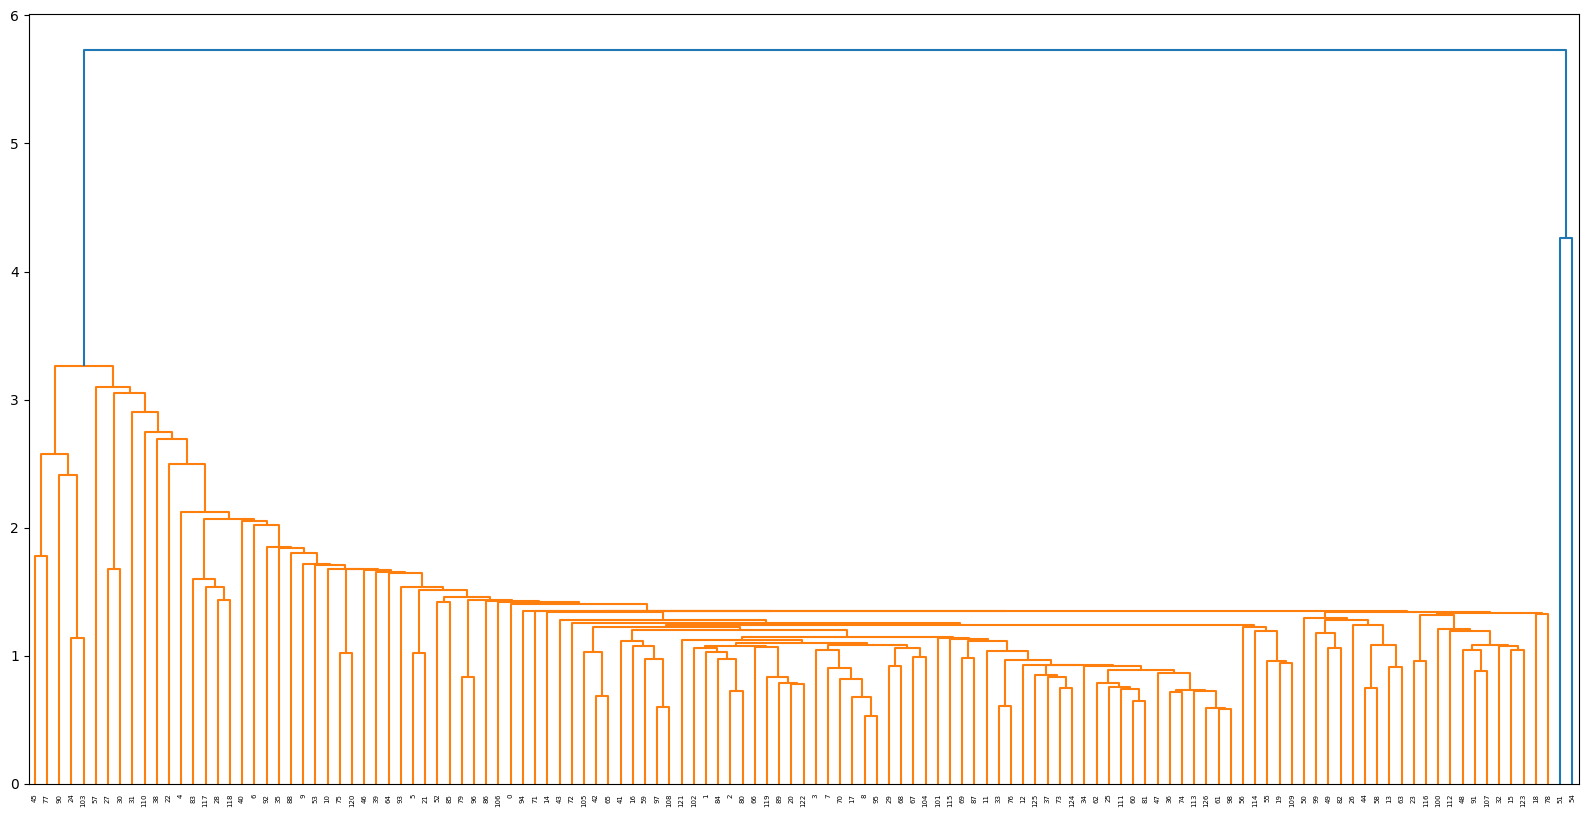

In [56]:
# Single linkage
plt.figure(figsize = (20,10))
mergings = linkage(df_final, method='single',metric='euclidean')
dendrogram(mergings)
plt.show()

### Complete Linkage

In complete linkage hierarchical clustering, the distance between two clusters is defined as the longest distance between two points in each cluster. For example, the distance between clusters “r” and “s” to the left is equal to the length of the arrow between their two furthest points.

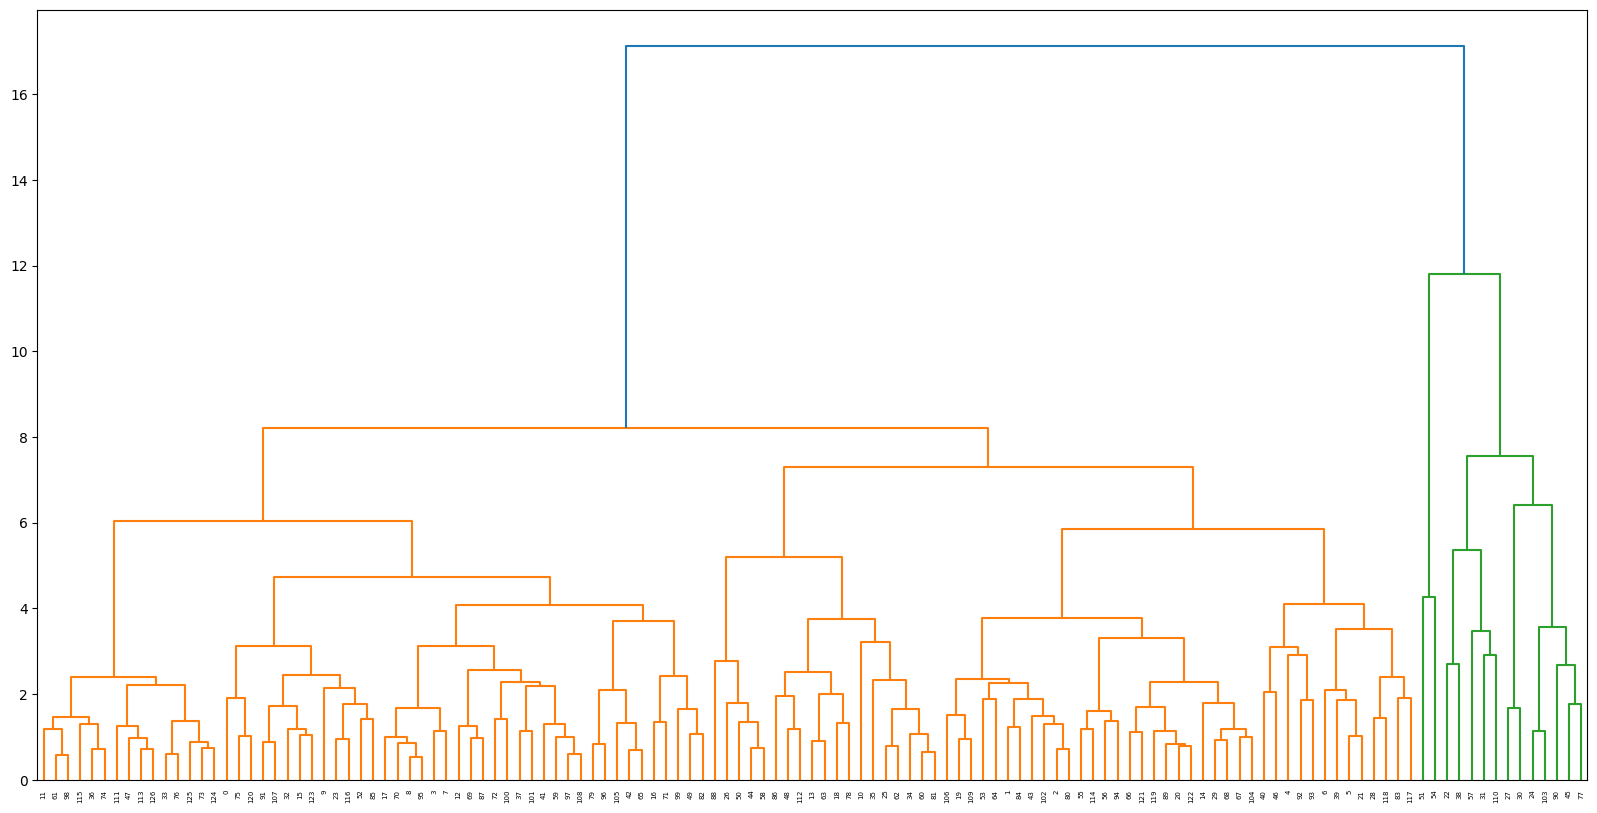

In [57]:
plt.figure(figsize = (20,10))
mergings = linkage(df_final, method='complete',metric='euclidean')
dendrogram(mergings)
plt.show()

### Finding the Optimal Number of Clusters

Complete Linkage suggests 3 clusters.

In [58]:
df_hc = df.copy()
df_hc = df_hc.drop('cluster_id',axis=1)
df_hc.head()

team_name           player_name          player_role    Mat   Inns    NO  \
0  Afghanistan  Hashmatullah Shahidi     Top order Batter   70.0  70.00  11.0   
1  Afghanistan    Rahmanullah Gurbaz  Wicketkeeper Batter   32.0  32.00   1.0   
2  Afghanistan        Ibrahim Zadran       Opening Batter   25.0  25.00   2.0   
3  Afghanistan          Reyaz Hassan               Batter    6.3   5.04   0.0   
4  Afghanistan   Rahmat Shah Zurmati           Allrounder  103.0  99.00   4.0   

     Runs     HS    Ave      BF     SR  100    50    0   4s  6s start   end  \
0  2001.0   97.0  33.91  2962.0  67.55  0.0  18.0  5.0  173  12  2013  2023   
1  1182.0  151.0  38.12  1349.0  87.62  5.0   4.0  1.0  107  44  2021  2023   
2  1123.0  162.0  48.82  1366.0  82.21  4.0   5.0  2.0  119  15  2019  2023   
3   120.0   50.0  30.00   192.0  62.50  0.0   1.0  0.0   12   2  2022  2023   
4  3481.0  114.0  36.64  4902.0  71.01  5.0  25.0  5.0  300  38  2013  2023   

   experience  
0        10.0  
1         2.0  
2         4.0  
3         1.0  
4        10.0

In [59]:
# 4 clusters
cluster_labels = cut_tree(mergings, n_clusters=4).reshape(-1, )
cluster_labels

array([0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1,
       2, 0, 2, 1, 1, 2, 1, 1, 2, 2, 0, 0, 1, 1, 0, 0, 2, 1, 1, 0, 0, 1,
       1, 2, 1, 0, 1, 0, 1, 3, 0, 1, 3, 1, 1, 2, 1, 0, 1, 0, 1, 1, 1, 0,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0,
       1, 1, 2, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 0, 1, 0, 0, 1,
       2, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0])

In [60]:
df_hc['cluster_labels'] = cluster_labels
df_hc.head()

team_name           player_name          player_role    Mat   Inns    NO  \
0  Afghanistan  Hashmatullah Shahidi     Top order Batter   70.0  70.00  11.0   
1  Afghanistan    Rahmanullah Gurbaz  Wicketkeeper Batter   32.0  32.00   1.0   
2  Afghanistan        Ibrahim Zadran       Opening Batter   25.0  25.00   2.0   
3  Afghanistan          Reyaz Hassan               Batter    6.3   5.04   0.0   
4  Afghanistan   Rahmat Shah Zurmati           Allrounder  103.0  99.00   4.0   

     Runs     HS    Ave      BF     SR  100    50    0   4s  6s start   end  \
0  2001.0   97.0  33.91  2962.0  67.55  0.0  18.0  5.0  173  12  2013  2023   
1  1182.0  151.0  38.12  1349.0  87.62  5.0   4.0  1.0  107  44  2021  2023   
2  1123.0  162.0  48.82  1366.0  82.21  4.0   5.0  2.0  119  15  2019  2023   
3   120.0   50.0  30.00   192.0  62.50  0.0   1.0  0.0   12   2  2022  2023   
4  3481.0  114.0  36.64  4902.0  71.01  5.0  25.0  5.0  300  38  2013  2023   

   experience  cluster_labels  
0        10.0               0  
1         2.0               1  
2         4.0               1  
3         1.0               0  
4        10.0               1

In [61]:
df_hc['cluster_labels'].value_counts()

1    58
0    55
2    12
3     2
Name: cluster_labels, dtype: int64

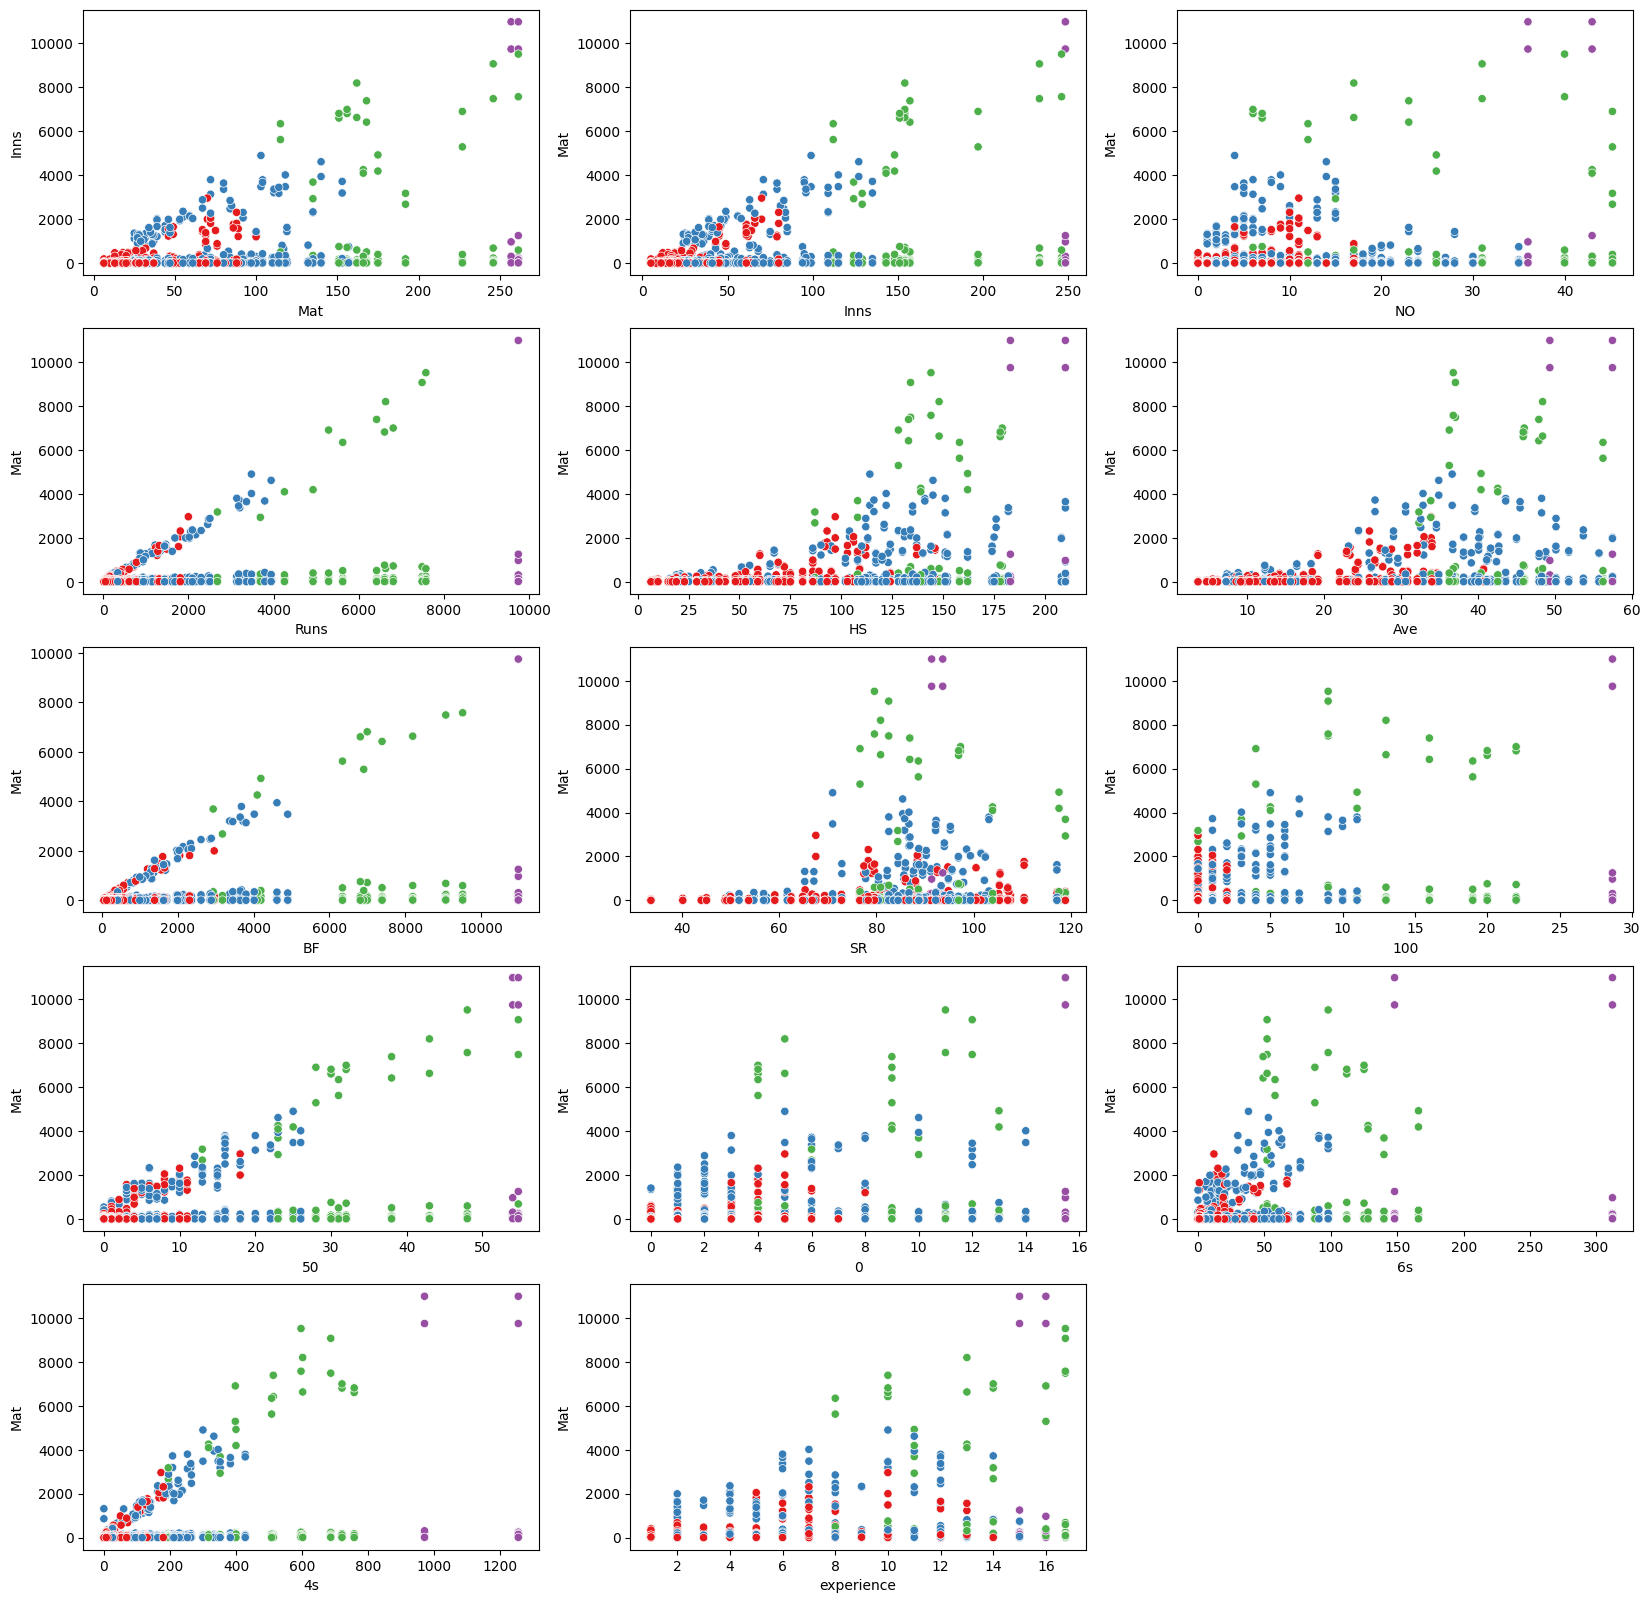

In [62]:
params = ['Mat', 'Inns', 'NO', 'Runs', 'HS', 'Ave', 'BF', 'SR', '100', '50', '0', '6s', '4s', 'experience']
# Scatter pair plot
plt.figure(figsize=(20, 20))
for i in enumerate(params):
    for j in enumerate(params):
        if i != j:
            plt.subplot(5, 3, i[0] + 1)
            sns.scatterplot(x=i[1], y=j[1], hue=df_hc['cluster_labels'], data=df, palette='Set1', legend=False)
plt.show()

In [63]:
df_hc[df_hc['cluster_labels'] == 0]

team_name           player_name          player_role    Mat   Inns  \
0     Afghanistan  Hashmatullah Shahidi     Top order Batter   70.0  70.00   
3     Afghanistan          Reyaz Hassan               Batter    6.3   5.04   
7     Afghanistan        Ikram Ali Khil  Wicketkeeper Batter   18.0  15.00   
8     Afghanistan    Azmatullah Omarzai           Allrounder   19.0  13.00   
9     Afghanistan     Rashid Khan Arman   Bowling Allrounder  100.0  79.00   
12    Afghanistan      Fazalhaq Farooqi               Bowler   26.0  14.00   
14    Afghanistan   Naveen ul Haq Murid               Bowler   13.0   9.00   
17      Australia            Alex Carey  Wicketkeeper Batter   72.0  66.00   
19      Australia           Sean Abbott   Bowling Allrounder   17.0  14.00   
20      Australia         Cameron Green   Batting Allrounder   22.0  19.00   
26      Australia        Marcus Stoinis   Batting Allrounder   67.0  61.00   
37     Bangladesh    Mehidy Hasan Miraz           Allrounder   89.0  62.00   
39     Bangladesh     Shak Mahedi Hasan           Allrounder   10.0   9.00   
42     Bangladesh          Hasan Mahmud               Bowler   20.0  12.00   
43     Bangladesh        Shoriful Islam               Bowler   29.0  18.00   
50        England            Sam Curran           Allrounder   29.0  22.00   
51        England      Liam Livingstone   Batting Allrounder   21.0  19.00   
56        England          Reece Topley               Bowler   29.0  14.00   
58        England             Mark Wood               Bowler   65.0  25.00   
61          India         Hardik Pandya           Allrounder   86.0  61.00   
68          India        Shardul Thakur               Bowler   47.0  25.00   
70          India        Mohammed Siraj               Bowler   36.0  13.00   
74          India     Surya Kumar Yadav               Batter   32.0  30.00   
80    Netherlands     Paul van Meekeren               Bowler   19.0  16.00   
81    Netherlands       Colin Ackermann   Batting Allrounder   13.0  12.00   
82    Netherlands  Roelof van der Merwe   Bowling Allrounder   21.0  13.00   
83    Netherlands        Logan van Beek               Bowler   30.0  29.00   
84    Netherlands            Aryan Dutt               Bowler   31.0  24.00   
85    Netherlands            Ryan Klein               Bowler   13.0   9.00   
86    Netherlands        Wesley Barresi               Batter   46.0  45.00   
87    Netherlands        Saqib Zulfiqar   Bowling Allrounder   14.0  14.00   
92    New Zealand          Mark Chapman           Allrounder   17.0  15.00   
95    New Zealand            Matt Henry               Bowler   81.0  34.00   
98    New Zealand         Jimmy Neesham   Batting Allrounder   75.0  64.00   
102   New Zealand             Ish Sodhi               Bowler   49.0  24.00   
106      Pakistan           Shadab Khan           Allrounder   69.0  43.00   
111      Pakistan          Saud Shakeel  Middle order Batter   13.0  11.00   
112      Pakistan        Iftikhar Ahmed  Middle order Batter   26.0  23.00   
114      Pakistan        Mohammad Nawaz           Allrounder   37.0  28.00   
116      Pakistan            Haris Rauf               Bowler   35.0  14.00   
117      Pakistan             Hasan Ali               Bowler   65.0  38.00   
118      Pakistan        Shaheen Afridi               Bowler   51.0  28.00   
119      Pakistan        Mohammad Wasim   Bowling Allrounder   18.0   8.00   
124  South Africa          Marco Jansen   Bowling Allrounder   20.0  17.00   
126  South Africa    Andile Phehlukwayo   Bowling Allrounder   76.0  49.00   
127  South Africa        Keshav Maharaj               Bowler   37.0  19.00   
130  South Africa           Lungi Ngidi               Bowler   53.0  21.00   
132  South Africa        Tabraiz Shamsi               Bowler   48.0  11.00   
134  South Africa       Lizaad Williams               Bowler    6.3   5.04   
135     Sri Lanka         Dasun Shanaka           Allrounder   69.0  61.00   
139     Sri Lanka    Dimuth Ka

In [64]:
df_hc[df_hc['cluster_labels'] == 1]

team_name             player_name          player_role    Mat   Inns  \
1     Afghanistan      Rahmanullah Gurbaz  Wicketkeeper Batter   32.0   32.0   
2     Afghanistan          Ibrahim Zadran       Opening Batter   25.0   25.0   
4     Afghanistan     Rahmat Shah Zurmati           Allrounder  103.0   99.0   
5     Afghanistan       Najibullah Zadran  Middle order Batter   92.0   84.0   
6     Afghanistan  Mohammad Nabi Eisakhil           Allrounder  153.0  135.0   
10    Afghanistan        Mujeeb ur Rahman               Bowler   72.0   39.0   
15      Australia             Pat Cummins               Bowler   83.0   54.0   
16      Australia             Steve Smith       Opening Batter   28.0   24.0   
21      Australia          Josh Hazlewood               Bowler   80.0   30.0   
22      Australia             Travis Head  Middle order Batter   59.0   56.0   
23      Australia      Marnus Labuschagne               Batter   44.0   42.0   
24      Australia             Mitch Marsh           Allrounder   85.0   81.0   
28      Australia              Adam Zampa               Bowler   91.0   46.0   
29      Australia          Mitchell Starc               Bowler  117.0   68.0   
31     Bangladesh        Litton Kumer Das  Wicketkeeper Batter   84.0   83.0   
33     Bangladesh   Najmul Hossain Shanto     Top order Batter   37.0   36.0   
40     Bangladesh            Taskin Ahmed               Bowler   68.0   37.0   
41     Bangladesh       Mustafizur Rahman               Bowler  100.0   51.0   
46        England               Moeen Ali   Batting Allrounder  135.0  109.0   
48        England          Jonny Bairstow  Wicketkeeper Batter  104.0   95.0   
52        England             Dawid Malan     Top order Batter   27.0   27.0   
53        England             Adil Rashid               Bowler  132.0   65.0   
55        England              Ben Stokes           Allrounder  111.0   96.0   
57        England            David Willey   Bowling Allrounder   70.0   43.0   
59        England            Chris Woakes           Allrounder  119.0   85.0   
62          India            Shubman Gill       Opening Batter   39.0   39.0   
64          India            Shreyas Iyer     Top order Batter   53.0   48.0   
65          India                KL Rahul  Wicketkeeper Batter   67.0   63.0   
67          India     Ravichandran Ashwin   Bowling Allrounder  116.0   63.0   
69          India          Jasprit Bumrah               Bowler   84.0   24.0   
71          India           Kuldeep Yadav               Bowler   96.0   35.0   
72          India          Mohammed Shami               Bowler   96.0   46.0   
73          India            Ishan Kishan  Wicketkeeper Batter   27.0   24.0   
75    Netherlands           Scott Edwards  Wicketkeeper Batter   44.0   41.0   
76    Netherlands              Max O'Dowd       Opening Batter   39.0   39.0   
77    Netherlands            Bas de Leede   Batting Allrounder   36.0   35.0   
91    New Zealand             Trent Boult               Bowler  110.0   50.0   
93    New Zealand            Devon Conway  Wicketkeeper Batter   28.0   27.0   
94    New Zealand         Lockie Ferguson               Bowler   63.0   29.0   
96    New Zealand              Tom Latham  Wicketkeeper Batter  140.0  127.0   
97    New Zealand          Daryl Mitchell   Batting Allrounder   35.0   31.0   
101   New Zealand           Mitch Santner   Bowling Allrounder  100.0   75.0   
103   New Zealand             Tim Southee               Bowler  157.0   94.0   
104   New Zealand              Will Young     Top order Batter   27.0   27.0   
107      Pakistan            Fakhar Zaman       Opening Batter   80.0   79.0   
108      Pakistan             Imam-ul-Haq     Top order Batter   72.0   71.0   
110      Pakistan         Mohammad Rizwan  Wicketkeeper Batter   72.0   66.0   
120  South Africa            Temba Bavuma  Middle order Batter   34.0   33.0   
123  South Africa         Reeza Hendricks       Opening Batter   31.0   31.0   
125  Sou

In [65]:
df_hc[df_hc['cluster_labels'] == 2]

team_name        player_name          player_role     Mat   Inns  \
25      Australia      Glenn Maxwell   Batting Allrounder  135.00  124.0   
27      Australia       David Warner       Opening Batter  156.00  154.0   
30     Bangladesh    Shakib Al Hasan           Allrounder  246.00  233.0   
35     Bangladesh    Mushfiqur Rahim  Wicketkeeper Batter  261.44  246.0   
36     Bangladesh  Mahmudullah Riyad           Allrounder  227.00  197.0   
45        England        Jos Buttler  Wicketkeeper Batter  175.00  148.0   
54        England           Joe Root     Top order Batter  168.00  157.0   
66          India    Ravindra Jadeja           Allrounder  192.00  129.0   
90    New Zealand    Kane Williamson     Top order Batter  162.00  154.0   
105      Pakistan         Babar Azam               Batter  115.00  112.0   
122  South Africa    Quinton de Kock  Wicketkeeper Batter  151.00  151.0   
129  South Africa       David Miller  Middle order Batter  166.00  143.0   

        NO    Runs     HS    Ave      BF        SR   100     50     0   4s  \
25   15.00  3691.0  108.0  33.86  2935.0  118.8298   3.0  23.00  10.0  352   
27    6.00  6810.0  179.0  46.01  7000.0   97.2800  22.0  32.00   4.0  721   
30   31.00  7488.0  134.0  37.06  9073.0   82.5300   9.0  54.74  12.0  687   
35   40.00  7577.0  144.0  36.78  9519.0   79.5900   9.0  48.00  11.0  597   
36   45.22  5294.0  128.0  36.26  6908.0   76.6300   4.0  28.00   9.0  398   
45   26.00  4928.0  162.0  40.39  4193.0  117.5200  11.0  25.00  13.0  400   
54   23.00  6421.0  133.0  47.91  7392.0   86.8600  16.0  38.00   9.0  513   
66   45.22  2683.0   87.0  32.32  3179.0   84.3900   0.0  13.00   6.0  195   
90   17.00  6632.0  148.0  48.40  8201.0   80.8600  13.0  43.00   5.0  602   
105  12.00  5625.0  158.0  56.25  6347.0   88.6200  19.0  31.00   4.0  508   
122   7.00  6607.0  178.0  45.88  6818.0   96.9000  20.0  30.00   4.0  758   
129  43.00  4257.0  139.0  42.57  4098.0  103.8700   5.0  23.00   9.0  317   

      6s start   end  experience  cluster_labels  
25   140  2012  2023       11.00               2  
27   125  2009  2023       14.00               2  
30    52  2006  2023       16.74               2  
35    98  2006  2023       16.74               2  
36    88  2007  2023       16.00               2  
45   166  2012  2023       11.00               2  
54    49  2013  2023       10.00               2  
66    52  2009  2023       14.00               2  
90    52  2010  2023       13.00               2  
105   58  2015  2023        8.00               2  
122  112  2013  2023       10.00               2  
129  128  2010  2023       13.00               2

In [66]:
df_hc[df_hc['cluster_labels'] == 3]

team_name   player_name       player_role     Mat    Inns    NO     Runs  \
60     India  Rohit Sharma  Top order Batter  257.00  248.22  36.0  9747.42   
63     India   Virat Kohli  Top order Batter  261.44  248.22  43.0  9747.42   

       HS      Ave       BF     SR    100     50      0    4s   6s start  \
60  210.0  49.3400  10987.9  91.35  28.66  54.00  15.48   971  312  2007   
63  183.0  57.4784  10987.9  93.63  28.66  54.74  15.48  1255  148  2008   

     end  experience  cluster_labels  
60  2023        16.0               3  
63  2023        15.0               3

### About the clusters

We can see we did get 4 clusters quite similar to K-Means Clustering. But the clusters are not as well defined as K-Means Clustering. The 4th cluster lacks some players which are now in the 2nd cluster. This is because of the way Hierarchical Clustering works. It is not as good as K-Means Clustering in this case.

DBScan was meaningless in this case. It is not a good clustering algorithm for this dataset.

## DBSCAN Clustering


In [107]:
# 4 clusters

df_dbscan = df.copy()

dbscan = DBSCAN(min_samples=4, eps=1)
dbscan.fit(df_final)


DBSCAN(eps=1, min_samples=4)

In [108]:
df_dbscan['cluster_id'] = dbscan.labels_
df_dbscan


team_name           player_name          player_role    Mat   Inns  \
0    Afghanistan  Hashmatullah Shahidi     Top order Batter   70.0  70.00   
1    Afghanistan    Rahmanullah Gurbaz  Wicketkeeper Batter   32.0  32.00   
2    Afghanistan        Ibrahim Zadran       Opening Batter   25.0  25.00   
3    Afghanistan          Reyaz Hassan               Batter    6.3   5.04   
4    Afghanistan   Rahmat Shah Zurmati           Allrounder  103.0  99.00   
..           ...                   ...                  ...    ...    ...   
141    Sri Lanka      Charith Asalanka   Batting Allrounder   47.0  41.00   
142    Sri Lanka   Dhananjaya de Silva           Allrounder   88.0  80.00   
144    Sri Lanka    Maheesh Theekshana               Bowler   32.0  17.00   
146    Sri Lanka         Kasun Rajitha               Bowler   32.0  17.00   
148    Sri Lanka         Lahiru Kumara               Bowler   28.0  16.00   

       NO    Runs     HS    Ave      BF     SR  100    50    0   4s  6s start  \
0    11.0  2001.0   97.0  33.91  2962.0  67.55  0.0  18.0  5.0  173  12  2013   
1     1.0  1182.0  151.0  38.12  1349.0  87.62  5.0   4.0  1.0  107  44  2021   
2     2.0  1123.0  162.0  48.82  1366.0  82.21  4.0   5.0  2.0  119  15  2019   
3     0.0   120.0   50.0  30.00   192.0  62.50  0.0   1.0  0.0   12   2  2022   
4     4.0  3481.0  114.0  36.64  4902.0  71.01  5.0  25.0  5.0  300  38  2013   
..    ...     ...    ...    ...     ...    ...  ...   ...  ...  ...  ..   ...   
141   5.0  1443.0  110.0  40.08  1626.0  88.74  1.0  10.0  2.0  116  28  2021   
142  10.0  1812.0   93.0  25.88  2313.0  78.33  0.0  10.0  4.0  180  15  2016   
144   6.0   149.0   29.0  13.54   252.0  59.12  0.0   0.0  4.0    8   2  2021   
146   7.0   103.0   33.0  10.30   165.0  62.42  0.0   0.0  3.0   12   1  2018   
148   6.0    55.0   10.0   5.50   122.0  45.08  0.0   0.0  1.0    7   1  2017   

      end  experience  cluster_id  
0    2023        10.0          -1  
1    2023         2.0          -1  
2    2023         4.0          -1  
3    2023         1.0          -1  
4    2023        10.0          -1  
..    ...         ...         ...  
141  2023         2.0           1  
142  2023         7.0          -1  
144  2023         2.0           2  
146  2023         5.0           2  
148  2023         6.0           2  

[127 rows x 20 columns]

In [109]:
df_dbscan['cluster_id'].value_counts()

-1    99
 2    19
 0     5
 1     4
Name: cluster_id, dtype: int64

In [110]:
df_dbscan[df_dbscan['cluster_id'] == 0]

team_name         player_name          player_role   Mat  Inns   NO  \
7    Afghanistan      Ikram Ali Khil  Wicketkeeper Batter  18.0  15.0  4.0   
8    Afghanistan  Azmatullah Omarzai           Allrounder  19.0  13.0  3.0   
20     Australia       Cameron Green   Batting Allrounder  22.0  19.0  7.0   
81   Netherlands     Colin Ackermann   Batting Allrounder  13.0  12.0  0.0   
111     Pakistan        Saud Shakeel  Middle order Batter  13.0  11.0  1.0   

      Runs    HS    Ave     BF     SR  100   50    0  4s  6s start   end  \
7    315.0  86.0  28.63  482.0  65.35  0.0  3.0  0.0  25   3  2019  2023   
8    340.0  73.0  34.00  385.0  88.31  0.0  3.0  0.0  28  12  2021  2023   
20   395.0  89.0  32.91  478.0  82.63  0.0  1.0  0.0  31   9  2020  2023   
81   363.0  81.0  30.25  474.0  76.58  0.0  3.0  0.0  35   2  2021  2023   
111  288.0  68.0  28.80  316.0  91.13  0.0  3.0  0.0  33   1  2021  2023   

     experience  cluster_id  
7           4.0           0  
8           2.0           0  
20          3.0           0  
81          2.0           0  
111         2.0           0

In [111]:
df_dbscan[df_dbscan['cluster_id'] == 1]

team_name         player_name         player_role   Mat  Inns   NO  \
23     Australia  Marnus Labuschagne              Batter  44.0  42.0  2.0   
104  New Zealand          Will Young    Top order Batter  27.0  27.0  3.0   
138    Sri Lanka     Pathum Nissanka    Top order Batter  46.0  46.0  4.0   
141    Sri Lanka    Charith Asalanka  Batting Allrounder  47.0  41.0  5.0   

       Runs     HS    Ave      BF     SR  100    50    0   4s  6s start   end  \
23   1469.0  124.0  36.72  1709.0  85.95  2.0   9.0  2.0  118   6  2020  2023   
104   991.0  120.0  41.29  1157.0  85.65  2.0   7.0  3.0  102  20  2021  2023   
138  1685.0  137.0  40.11  1995.0  84.46  3.0  13.0  3.0  212   9  2021  2023   
141  1443.0  110.0  40.08  1626.0  88.74  1.0  10.0  2.0  116  28  2021  2023   

     experience  cluster_id  
23          3.0           1  
104         2.0           1  
138         2.0           1  
141         2.0           1

In [112]:
df_dbscan[df_dbscan['cluster_id'] == 2]

team_name          player_name         player_role   Mat  Inns    NO  \
14    Afghanistan  Naveen ul Haq Murid              Bowler  13.0   9.0   5.0   
28      Australia           Adam Zampa              Bowler  91.0  46.0  17.0   
40     Bangladesh         Taskin Ahmed              Bowler  68.0  37.0  10.0   
42     Bangladesh         Hasan Mahmud              Bowler  20.0  12.0   4.0   
43     Bangladesh       Shoriful Islam              Bowler  29.0  18.0   8.0   
56        England         Reece Topley              Bowler  29.0  14.0  11.0   
69          India       Jasprit Bumrah              Bowler  84.0  24.0  13.0   
70          India       Mohammed Siraj              Bowler  36.0  13.0   7.0   
71          India        Kuldeep Yadav              Bowler  96.0  35.0  18.0   
84    Netherlands           Aryan Dutt              Bowler  31.0  24.0   6.0   
85    Netherlands           Ryan Klein              Bowler  13.0   9.0   2.0   
87    Netherlands       Saqib Zulfiqar  Bowling Allrounder  14.0  14.0   2.0   
94    New Zealand      Lockie Ferguson              Bowler  63.0  29.0  13.0   
116      Pakistan           Haris Rauf              Bowler  35.0  14.0   7.0   
130  South Africa          Lungi Ngidi              Bowler  53.0  21.0  14.0   
132  South Africa       Tabraiz Shamsi              Bowler  48.0  11.0   7.0   
144     Sri Lanka   Maheesh Theekshana              Bowler  32.0  17.0   6.0   
146     Sri Lanka        Kasun Rajitha              Bowler  32.0  17.0   7.0   
148     Sri Lanka        Lahiru Kumara              Bowler  28.0  16.0   6.0   

      Runs    HS    Ave     BF     SR  100   50    0  4s  6s start   end  \
14    35.0  10.0   8.75   50.0  70.00  0.0  0.0  2.0   5   0  2016  2023   
28   256.0  36.0   8.82  415.0  61.68  0.0  0.0  5.0  22   1  2016  2023   
40   199.0  21.0   7.37  363.0  54.82  0.0  0.0  7.0  12   7  2014  2023   
42    45.0  15.0   5.62   92.0  48.91  0.0  0.0  3.0   6   0  2021  2023   
43    77.0  16.0   7.70   97.0  79.38  0.0  0.0  1.0   5   3  2021  2023   
56    35.0  15.0  11.66   70.0  50.00  0.0  0.0  1.0   3   1  2015  2023   
69    89.0  16.0   8.09  155.0  57.41  0.0  0.0  5.0  10   1  2016  2023   
70    37.0   9.0   6.16   92.0  40.21  0.0  0.0  1.0   2   0  2019  2023   
71   179.0  19.0  10.52  315.0  56.82  0.0  0.0  3.0  14   0  2017  2023   
84   154.0  23.0   8.55  222.0  69.36  0.0  0.0  3.0   8   7  2021  2023   
85    43.0   8.0   6.14   80.0  53.75  0.0  0.0  1.0   1   0  2022  2023   
87   191.0  34.0  15.91  286.0  66.78  0.0  0.0  1.0  15   4  2019  2023   
94   116.0  19.0   7.25  233.0  49.78  0.0  0.0  4.0   6   2  2016  2023   
116   33.0  16.0   4.71   67.0  49.25  0.0  0.0  1.0   3   1  2020  2023   
130   91.0  19.0  13.00  182.0  50.00  0.0  0.0  3.0   5   5  2018  2023   
132   22.0   9.0   5.50   50.0  44.00  0.0  0.0  3.0   1   0  2016  2023   
144  149.0  29.0  13.54  252.0  59.12  0.0  0.0  4.0   8   2  2021  2023   
146  103.0  33.0  10.30  165.0  62.42  0.0  0.0  3.0  12   1  2018  2023   
148   55.0  10.0   5.50  122.0  45.08  0.0  0.0  1.0   7   1  2017  2023   

     experience  cluster_id  
14          7.0           2  
28          7.0           2  
40          9.0           2  
42          2.0           2  
43          2.0           2  
56          8.0           2  
69          7.0           2  
70          4.0           2  
71          6.0           2  
84          2.0           2  
85          1.0           2  
87          4.0           2  
94          7.0           2  
116         3.0           2  
130         5.0           2  
132         7.0           2  
144         2.0           2  
146         5.0           2  
148         6.0           2

### About the clusters

DBScan was meaningless in this case. It is not a good clustering algorithm for this dataset.

## Agglomerative Clustering


In [113]:
df_agg = df.copy()

agg = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='ward')
agg.fit(df_final)

AgglomerativeClustering(affinity='euclidean', n_clusters=4)

In [115]:
df_agg['cluster_id'] = agg.labels_
df_agg

team_name           player_name          player_role    Mat   Inns  \
0    Afghanistan  Hashmatullah Shahidi     Top order Batter   70.0  70.00   
1    Afghanistan    Rahmanullah Gurbaz  Wicketkeeper Batter   32.0  32.00   
2    Afghanistan        Ibrahim Zadran       Opening Batter   25.0  25.00   
3    Afghanistan          Reyaz Hassan               Batter    6.3   5.04   
4    Afghanistan   Rahmat Shah Zurmati           Allrounder  103.0  99.00   
..           ...                   ...                  ...    ...    ...   
141    Sri Lanka      Charith Asalanka   Batting Allrounder   47.0  41.00   
142    Sri Lanka   Dhananjaya de Silva           Allrounder   88.0  80.00   
144    Sri Lanka    Maheesh Theekshana               Bowler   32.0  17.00   
146    Sri Lanka         Kasun Rajitha               Bowler   32.0  17.00   
148    Sri Lanka         Lahiru Kumara               Bowler   28.0  16.00   

       NO    Runs     HS    Ave      BF     SR  100    50    0   4s  6s start  \
0    11.0  2001.0   97.0  33.91  2962.0  67.55  0.0  18.0  5.0  173  12  2013   
1     1.0  1182.0  151.0  38.12  1349.0  87.62  5.0   4.0  1.0  107  44  2021   
2     2.0  1123.0  162.0  48.82  1366.0  82.21  4.0   5.0  2.0  119  15  2019   
3     0.0   120.0   50.0  30.00   192.0  62.50  0.0   1.0  0.0   12   2  2022   
4     4.0  3481.0  114.0  36.64  4902.0  71.01  5.0  25.0  5.0  300  38  2013   
..    ...     ...    ...    ...     ...    ...  ...   ...  ...  ...  ..   ...   
141   5.0  1443.0  110.0  40.08  1626.0  88.74  1.0  10.0  2.0  116  28  2021   
142  10.0  1812.0   93.0  25.88  2313.0  78.33  0.0  10.0  4.0  180  15  2016   
144   6.0   149.0   29.0  13.54   252.0  59.12  0.0   0.0  4.0    8   2  2021   
146   7.0   103.0   33.0  10.30   165.0  62.42  0.0   0.0  3.0   12   1  2018   
148   6.0    55.0   10.0   5.50   122.0  45.08  0.0   0.0  1.0    7   1  2017   

      end  experience  cluster_id  
0    2023        10.0           0  
1    2023         2.0           0  
2    2023         4.0           0  
3    2023         1.0           0  
4    2023        10.0           2  
..    ...         ...         ...  
141  2023         2.0           0  
142  2023         7.0           0  
144  2023         2.0           3  
146  2023         5.0           3  
148  2023         6.0           3  

[127 rows x 20 columns]

In [116]:
df_agg['cluster_id'].value_counts()

0    72
3    28
2    18
1     9
Name: cluster_id, dtype: int64

In [125]:
pd.set_option('display.max_rows', None)
df_agg[df_agg['cluster_id'] == 0]

team_name             player_name          player_role    Mat   Inns  \
0     Afghanistan    Hashmatullah Shahidi     Top order Batter   70.0  70.00   
1     Afghanistan      Rahmanullah Gurbaz  Wicketkeeper Batter   32.0  32.00   
2     Afghanistan          Ibrahim Zadran       Opening Batter   25.0  25.00   
3     Afghanistan            Reyaz Hassan               Batter    6.3   5.04   
7     Afghanistan          Ikram Ali Khil  Wicketkeeper Batter   18.0  15.00   
8     Afghanistan      Azmatullah Omarzai           Allrounder   19.0  13.00   
9     Afghanistan       Rashid Khan Arman   Bowling Allrounder  100.0  79.00   
10    Afghanistan        Mujeeb ur Rahman               Bowler   72.0  39.00   
15      Australia             Pat Cummins               Bowler   83.0  54.00   
16      Australia             Steve Smith       Opening Batter   28.0  24.00   
17      Australia              Alex Carey  Wicketkeeper Batter   72.0  66.00   
19      Australia             Sean Abbott   Bowling Allrounder   17.0  14.00   
20      Australia           Cameron Green   Batting Allrounder   22.0  19.00   
21      Australia          Josh Hazlewood               Bowler   80.0  30.00   
22      Australia             Travis Head  Middle order Batter   59.0  56.00   
23      Australia      Marnus Labuschagne               Batter   44.0  42.00   
26      Australia          Marcus Stoinis   Batting Allrounder   67.0  61.00   
29      Australia          Mitchell Starc               Bowler  117.0  68.00   
33     Bangladesh   Najmul Hossain Shanto     Top order Batter   37.0  36.00   
37     Bangladesh      Mehidy Hasan Miraz           Allrounder   89.0  62.00   
50        England              Sam Curran           Allrounder   29.0  22.00   
51        England        Liam Livingstone   Batting Allrounder   21.0  19.00   
52        England             Dawid Malan     Top order Batter   27.0  27.00   
53        England             Adil Rashid               Bowler  132.0  65.00   
57        England            David Willey   Bowling Allrounder   70.0  43.00   
58        England               Mark Wood               Bowler   65.0  25.00   
59        England            Chris Woakes           Allrounder  119.0  85.00   
61          India           Hardik Pandya           Allrounder   86.0  61.00   
62          India            Shubman Gill       Opening Batter   39.0  39.00   
64          India            Shreyas Iyer     Top order Batter   53.0  48.00   
65          India                KL Rahul  Wicketkeeper Batter   67.0  63.00   
67          India     Ravichandran Ashwin   Bowling Allrounder  116.0  63.00   
68          India          Shardul Thakur               Bowler   47.0  25.00   
72          India          Mohammed Shami               Bowler   96.0  46.00   
73          India            Ishan Kishan  Wicketkeeper Batter   27.0  24.00   
74          India       Surya Kumar Yadav               Batter   32.0  30.00   
75    Netherlands           Scott Edwards  Wicketkeeper Batter   44.0  41.00   
76    Netherlands              Max O'Dowd       Opening Batter   39.0  39.00   
77    Netherlands            Bas de Leede   Batting Allrounder   36.0  35.00   
81    Netherlands         Colin Ackermann   Batting Allrounder   13.0  12.00   
82    Netherlands    Roelof van der Merwe   Bowling Allrounder   21.0  13.00   
86    Netherlands          Wesley Barresi               Batter   46.0  45.00   
91    New Zealand             Trent Boult               Bowler  110.0  50.00   
92    New Zealand            Mark Chapman           Allrounder   17.0  15.00   
93    New Zealand            Devon Conway  Wicketkeeper Batter   28.0  27.00   
95    New Zealand              Matt Henry               Bowler   81.0  34.00   
97    New Zealand          Daryl Mitchell   Batting Allrounder   35.0  31.00   
98    New Zealand           Jimmy Neesham   Batting Allrounder   75.0  64.00   
101   New Zealand           Mitch Santner   Bowling Allrounder  100.0  75.00   
103   Ne

In [118]:
df_agg[df_agg['cluster_id'] == 1]

team_name      player_name          player_role     Mat    Inns    NO  \
27      Australia     David Warner       Opening Batter  156.00  154.00   6.0   
30     Bangladesh  Shakib Al Hasan           Allrounder  246.00  233.00  31.0   
35     Bangladesh  Mushfiqur Rahim  Wicketkeeper Batter  261.44  246.00  40.0   
54        England         Joe Root     Top order Batter  168.00  157.00  23.0   
60          India     Rohit Sharma     Top order Batter  257.00  248.22  36.0   
63          India      Virat Kohli     Top order Batter  261.44  248.22  43.0   
90    New Zealand  Kane Williamson     Top order Batter  162.00  154.00  17.0   
105      Pakistan       Babar Azam               Batter  115.00  112.00  12.0   
122  South Africa  Quinton de Kock  Wicketkeeper Batter  151.00  151.00   7.0   

        Runs     HS      Ave       BF     SR    100     50      0    4s   6s  \
27   6810.00  179.0  46.0100   7000.0  97.28  22.00  32.00   4.00   721  125   
30   7488.00  134.0  37.0600   9073.0  82.53   9.00  54.74  12.00   687   52   
35   7577.00  144.0  36.7800   9519.0  79.59   9.00  48.00  11.00   597   98   
54   6421.00  133.0  47.9100   7392.0  86.86  16.00  38.00   9.00   513   49   
60   9747.42  210.0  49.3400  10987.9  91.35  28.66  54.00  15.48   971  312   
63   9747.42  183.0  57.4784  10987.9  93.63  28.66  54.74  15.48  1255  148   
90   6632.00  148.0  48.4000   8201.0  80.86  13.00  43.00   5.00   602   52   
105  5625.00  158.0  56.2500   6347.0  88.62  19.00  31.00   4.00   508   58   
122  6607.00  178.0  45.8800   6818.0  96.90  20.00  30.00   4.00   758  112   

    start   end  experience  cluster_id  
27   2009  2023       14.00           1  
30   2006  2023       16.74           1  
35   2006  2023       16.74           1  
54   2013  2023       10.00           1  
60   2007  2023       16.00           1  
63   2008  2023       15.00           1  
90   2010  2023       13.00           1  
105  2015  2023        8.00           1  
122  2013  2023       10.00           1

In [119]:
df_agg[df_agg['cluster_id'] == 2]

team_name             player_name          player_role    Mat   Inns  \
4     Afghanistan     Rahmat Shah Zurmati           Allrounder  103.0   99.0   
5     Afghanistan       Najibullah Zadran  Middle order Batter   92.0   84.0   
6     Afghanistan  Mohammad Nabi Eisakhil           Allrounder  153.0  135.0   
24      Australia             Mitch Marsh           Allrounder   85.0   81.0   
25      Australia           Glenn Maxwell   Batting Allrounder  135.0  124.0   
31     Bangladesh        Litton Kumer Das  Wicketkeeper Batter   84.0   83.0   
36     Bangladesh       Mahmudullah Riyad           Allrounder  227.0  197.0   
45        England             Jos Buttler  Wicketkeeper Batter  175.0  148.0   
46        England               Moeen Ali   Batting Allrounder  135.0  109.0   
48        England          Jonny Bairstow  Wicketkeeper Batter  104.0   95.0   
55        England              Ben Stokes           Allrounder  111.0   96.0   
66          India         Ravindra Jadeja           Allrounder  192.0  129.0   
96    New Zealand              Tom Latham  Wicketkeeper Batter  140.0  127.0   
107      Pakistan            Fakhar Zaman       Opening Batter   80.0   79.0   
108      Pakistan             Imam-ul-Haq     Top order Batter   72.0   71.0   
129  South Africa            David Miller  Middle order Batter  166.0  143.0   
136     Sri Lanka            Kusal Mendis  Wicketkeeper Batter  118.0  115.0   
137     Sri Lanka            Kusal Perera  Wicketkeeper Batter  114.0  109.0   

        NO    Runs     HS    Ave      BF        SR   100    50     0   4s  \
4     4.00  3481.0  114.0  36.64  4902.0   71.0100   5.0  25.0   5.0  300   
5    13.00  2060.0  104.0  29.01  2312.0   89.1000   1.0  15.0   4.0  178   
6    15.00  3194.0  116.0  26.61  3722.0   85.8100   1.0  16.0   6.0  208   
24   10.00  2456.0  121.0  34.59  2614.0   93.9500   2.0  18.0   6.0  225   
25   15.00  3691.0  108.0  33.86  2935.0  118.8298   3.0  23.0  10.0  352   
31    7.00  2475.0  176.0  32.56  2855.0   86.6900   5.0  12.0  12.0  265   
36   45.22  5294.0  128.0  36.26  6908.0   76.6300   4.0  28.0   9.0  398   
45   26.00  4928.0  162.0  40.39  4193.0  117.5200  11.0  25.0  13.0  400   
46   15.00  2301.0  128.0  24.47  2335.0   98.5400   3.0   6.0   6.0  197   
48    8.00  3794.0  141.0  43.60  3679.0  103.1200  11.0  16.0   8.0  428   
55   15.00  3207.0  182.0  39.59  3369.0   95.1900   4.0  22.0   7.0  263   
66   45.22  2683.0   87.0  32.32  3179.0   84.3900   0.0  13.0   6.0  195   
96   14.00  3944.0  145.0  34.90  4618.0   85.4000   7.0  23.0  10.0  333   
107   5.00  3365.0  210.0  45.47  3647.0   92.2600  10.0  16.0   6.0  383   
108   6.00  3138.0  151.0  48.27  3801.0   82.5500   9.0  20.0   3.0  253   
129  43.00  4257.0  139.0  42.57  4098.0  103.8700   5.0  23.0   9.0  317   
136   9.00  3483.0  122.0  32.85  4018.0   86.6800   3.0  26.0  14.0  346   
137   5.00  3182.0  135.0  30.59  3452.0   92.1700   6.0  16.0  12.0  352   

      6s start   end  experience  cluster_id  
4     38  2013  2023        10.0           2  
5     68  2012  2023        11.0           2  
6     98  2009  2023        14.0           2  
24    77  2011  2023        12.0           2  
25   140  2012  2023        11.0           2  
31    42  2015  2023         8.0           2  
36    88  2007  2023        16.0           2  
45   166  2012  2023        11.0           2  
46    77  2014  2023         9.0           2  
48    91  2011  2023        12.0           2  
55    98  2011  2023        12.0           2  
66    52  2009  2023        14.0           2  
96    53  2012  2023        11.0           2  
107   63  2017  2023         6.0           2  
108   30  2017  2023         6.0           2  
129  128  2010  2023        13.0           2  
136   61  2016  2023         7.0           2  
137   50  2013  2023        10.0           2

In [121]:
df_agg[df_agg['cluster_id'] == 3]

team_name          player_name         player_role    Mat   Inns  \
12    Afghanistan     Fazalhaq Farooqi              Bowler   26.0  14.00   
14    Afghanistan  Naveen ul Haq Murid              Bowler   13.0   9.00   
28      Australia           Adam Zampa              Bowler   91.0  46.00   
39     Bangladesh    Shak Mahedi Hasan          Allrounder   10.0   9.00   
40     Bangladesh         Taskin Ahmed              Bowler   68.0  37.00   
41     Bangladesh    Mustafizur Rahman              Bowler  100.0  51.00   
42     Bangladesh         Hasan Mahmud              Bowler   20.0  12.00   
43     Bangladesh       Shoriful Islam              Bowler   29.0  18.00   
56        England         Reece Topley              Bowler   29.0  14.00   
69          India       Jasprit Bumrah              Bowler   84.0  24.00   
70          India       Mohammed Siraj              Bowler   36.0  13.00   
71          India        Kuldeep Yadav              Bowler   96.0  35.00   
80    Netherlands    Paul van Meekeren              Bowler   19.0  16.00   
83    Netherlands       Logan van Beek              Bowler   30.0  29.00   
84    Netherlands           Aryan Dutt              Bowler   31.0  24.00   
85    Netherlands           Ryan Klein              Bowler   13.0   9.00   
87    Netherlands       Saqib Zulfiqar  Bowling Allrounder   14.0  14.00   
94    New Zealand      Lockie Ferguson              Bowler   63.0  29.00   
102   New Zealand            Ish Sodhi              Bowler   49.0  24.00   
116      Pakistan           Haris Rauf              Bowler   35.0  14.00   
118      Pakistan       Shaheen Afridi              Bowler   51.0  28.00   
119      Pakistan       Mohammad Wasim  Bowling Allrounder   18.0   8.00   
130  South Africa          Lungi Ngidi              Bowler   53.0  21.00   
132  South Africa       Tabraiz Shamsi              Bowler   48.0  11.00   
134  South Africa      Lizaad Williams              Bowler    6.3   5.04   
144     Sri Lanka   Maheesh Theekshana              Bowler   32.0  17.00   
146     Sri Lanka        Kasun Rajitha              Bowler   32.0  17.00   
148     Sri Lanka        Lahiru Kumara              Bowler   28.0  16.00   

       NO    Runs     HS      Ave     BF       SR  100   50    0  4s  6s  \
12    9.0   17.56   6.52   3.5926   51.0  33.6684  0.0  0.0  3.0   2   0   
14    5.0   35.00  10.00   8.7500   50.0  70.0000  0.0  0.0  2.0   5   0   
28   17.0  256.00  36.00   8.8200  415.0  61.6800  0.0  0.0  5.0  22   1   
39    1.0  120.00  29.00  15.0000  185.0  64.8600  0.0  0.0  0.0  10   2   
40   10.0  199.00  21.00   7.3700  363.0  54.8200  0.0  0.0  7.0  12   7   
41   30.0  160.00  20.00   7.6100  309.0  51.7700  0.0  0.0  9.0  18   1   
42    4.0   45.00  15.00   5.6200   92.0  48.9100  0.0  0.0  3.0   6   0   
43    8.0   77.00  16.00   7.7000   97.0  79.3800  0.0  0.0  1.0   5   3   
56   11.0   35.00  15.00  11.6600   70.0  50.0000  0.0  0.0  1.0   3   1   
69   13.0   89.00  16.00   8.0900  155.0  57.4100  0.0  0.0  5.0  10   1   
70    7.0   37.00   9.00   6.1600   92.0  40.2100  0.0  0.0  1.0   2   0   
71   18.0  179.00  19.00  10.5200  315.0  56.8200  0.0  0.0  3.0  14   0   
80    7.0   86.00  21.00   9.5500  108.0  79.6200  0.0  0.0  4.0   5   2   
83   10.0  457.00  59.00  24.0500  566.0  80.7400  0.0  1.0  3.0  29  12   
84    6.0  154.00  23.00   8.5500  222.0  69.3600  0.0  0.0  3.0   8   7   
85    2.0   43.00   8.00   6.1400   80.0  53.7500  0.0  0.0  1.0   1   0   
87    2.0  191.00  34.00  15.9100  286.0  66.7800  0.0  0.0  1.0  15   4   
94   13.0  116.00  19.00   7.2500  233.0  49.7800  0.0  0.0  4.0   6   2   
102   4.0  201.00  35.00  10.0500  276.0  72.8200  0.0  0.0  5.0   7  10   
116   7.0   33.00  16.00   4.7100   67.0  49.2500  0.0  0.0  1.0   3   1   
118  17.0  171.00  23.00  15.5400  216.0  79.1600  0.0  0.0  3.0  14   6   
119   1.0   64.00  17.00   9.1400   68.0  94.1100  0.0  0.0  1.0   3   4   
130  14.0   91.00  19.00  13.0000  182.0  50.0000  0.0 

### About the clusters

Agglomerative Clustering was 75% similar to K-Means Clustering. It is an okayish clustering algorithm for this dataset. The clusters are not as well defined as K-Means Clustering. The X-Factor Bowlers and explosive players were identified properly, but the top-class batsman and solid line up helpers were not identified properly. This is because of the way Agglomerative Clustering works. It is not as good as K-Means Clustering in this case.

# Conclusion

- We have clustered the players into 4 clusters using different clustering algos and found that K-Means Clustering is better than all in this case.
- We have identified the players who perform like Virat Kohli. (Top-class batsman)
- We have identified the players who are similar to Maxwell and Jadeja. (Explosive X-factor players)
- We have identified the players who are similar to Cummins, Hazlewood, Bumrah, Shami. (X-Factor Bowlers)
- We have identified the players who are similar to Shreyas Iyer, K L Rahul, Surya Kumar Yadav. (Strong Middle Order)